<IMG src="~/work/cartpole.png" width=500>

## Week 1

### Dynamical simulation

Consider the inverted pendulum system ("cartpole") drawn above, familiar from the coursework of 3F2, with a freely moving cart and freely rotating pendulum attached to the cart, moving under the action of an external action force and gravity. 


The equations of motion of the system are 

$$
\begin{array}{lll}
3 \ddot x \cos \theta  + 2 L \ddot \theta & = &  3 g \sin \theta - 6 \mu_\theta \dot\theta/mL\\
(m+M) \ddot x + \frac12 m L\ddot\theta\cos\theta - \frac12 mL{\dot\theta}^2 \sin\theta &=& F - \mu_x \dot x
\end{array}
$$

where the stationary points are $\theta=0$ (unstable) and $\theta=\pi$ (stable), and $F$ is the external _action_ (force) on the cart, $\mu_x$ and $\mu_\theta$ 
are the friction coefficients of the cart and the pole, respectively. 

#### Task 1.1

Study the code in the `CartPole.py` file, which creates a Python class to describe the system. Note the variables that describe to the state of system, and the `performAction()` function that updates the state variables using the _Euler_ algorithm (it does a small number of steps), using a given force (which is the 'action') on the cart. Passing a zero value for the force corresponds to free dynamics. 

Write code to simulate a “rollout” (i.e. a run with specified initial condition simulated for a number of time steps) using the `performAction` function in a loop, starting from the stable equilibrium position and some nonzero initial cart velocity or angular velocity, and no applied force. Plot the resulting time evolution of the system variables. Vary the size of the initial velocities to realize different behaviours: simple oscillation around the stable equilibrium, and also the complete rotation of the pendulum. Useful ranges are as follows. Cart velocity: $[-10,10]$, pole angle: $[-\pi,\pi]$, pole (angular) velocity: $[-15,15]$.

You can plot all variables as a function of time, and also pairs of variables against one another (similar to phase portraits).


Note how the angle is used in the dynamics as a continous variable, rather than just in the range $[-\pi,\pi]$. There is a `remap_angle` function in the `CartPole` module that you can use to get the angle in the usual range. _This will be an important consideration later on when we develop models of the dynamics._


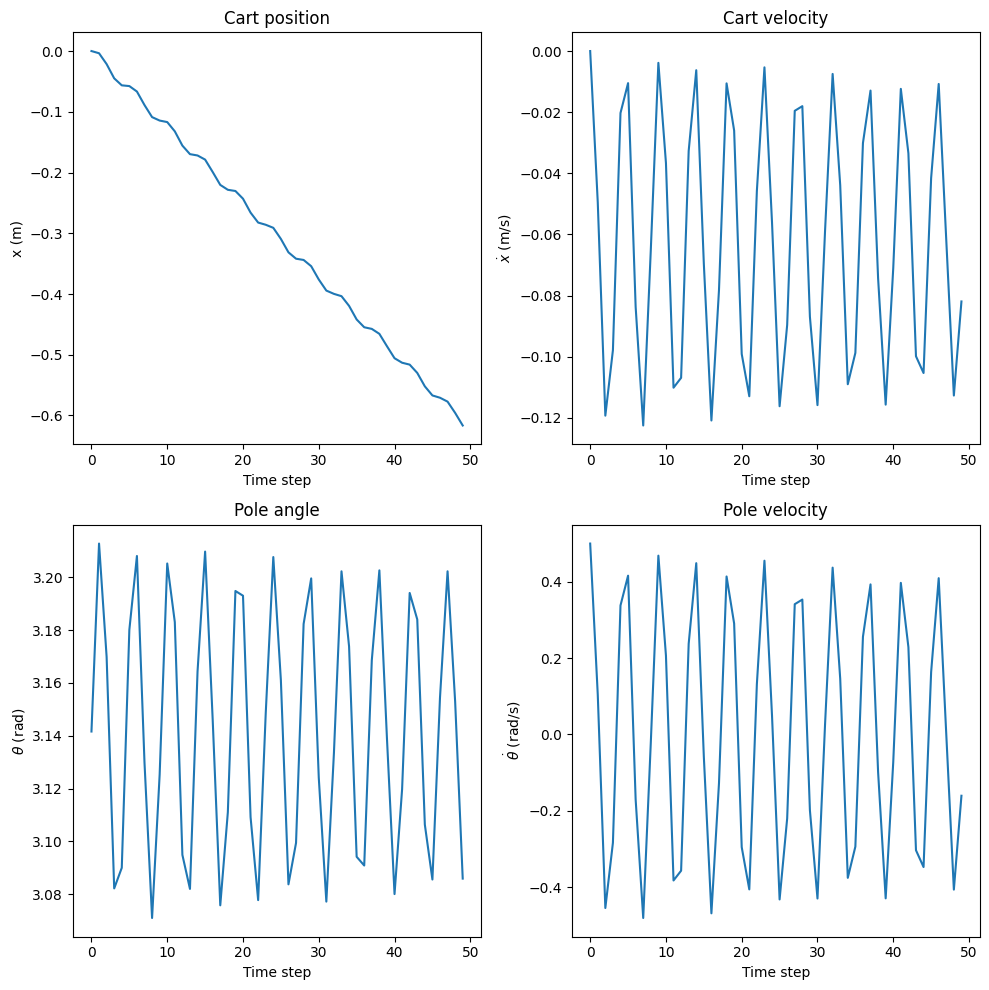

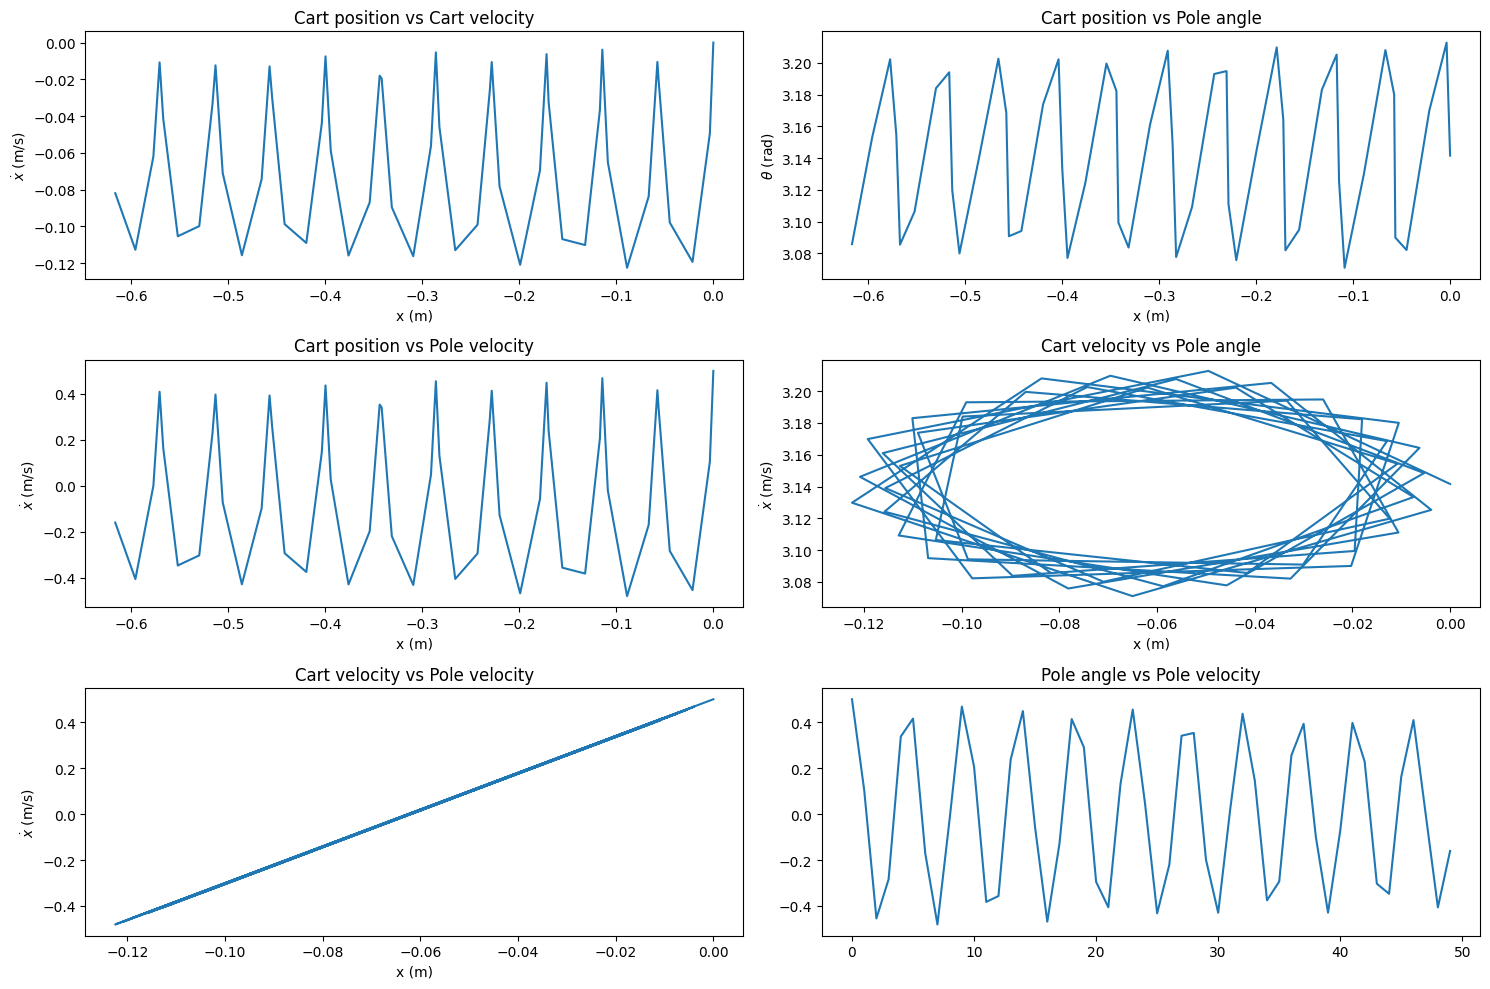

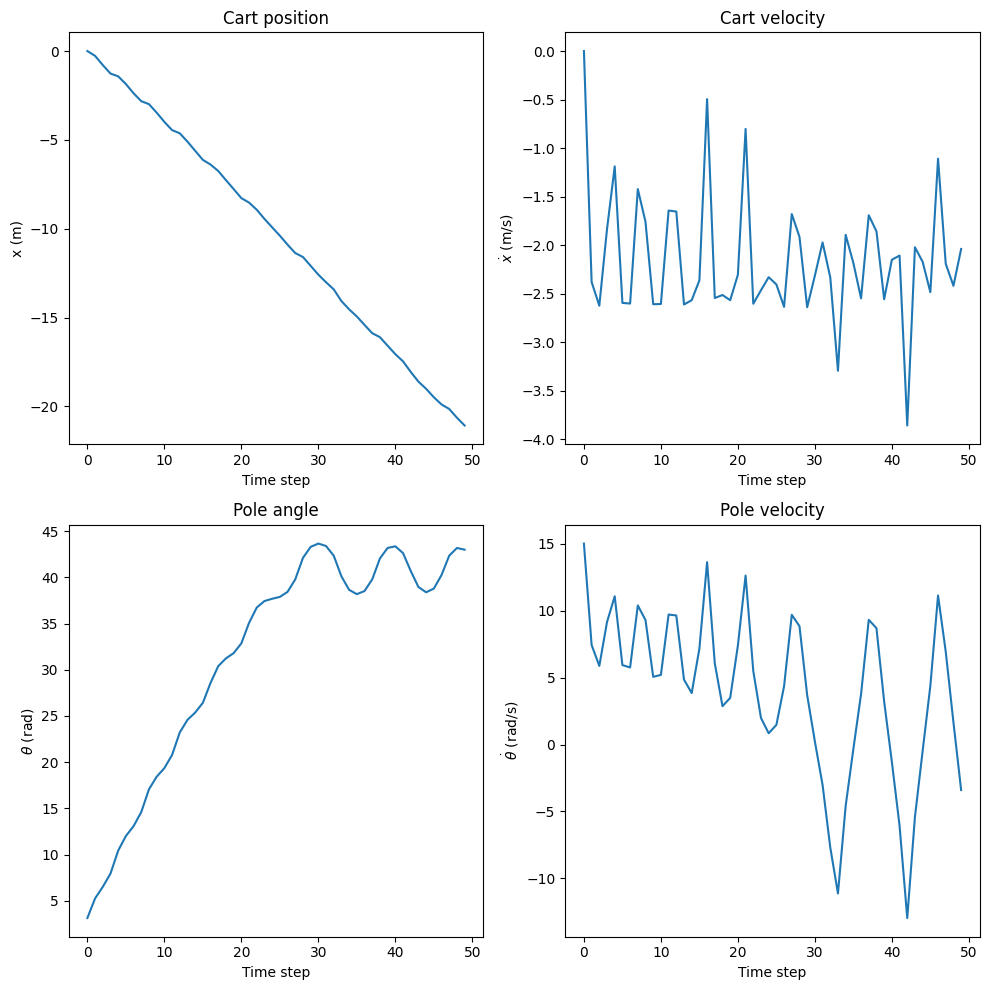

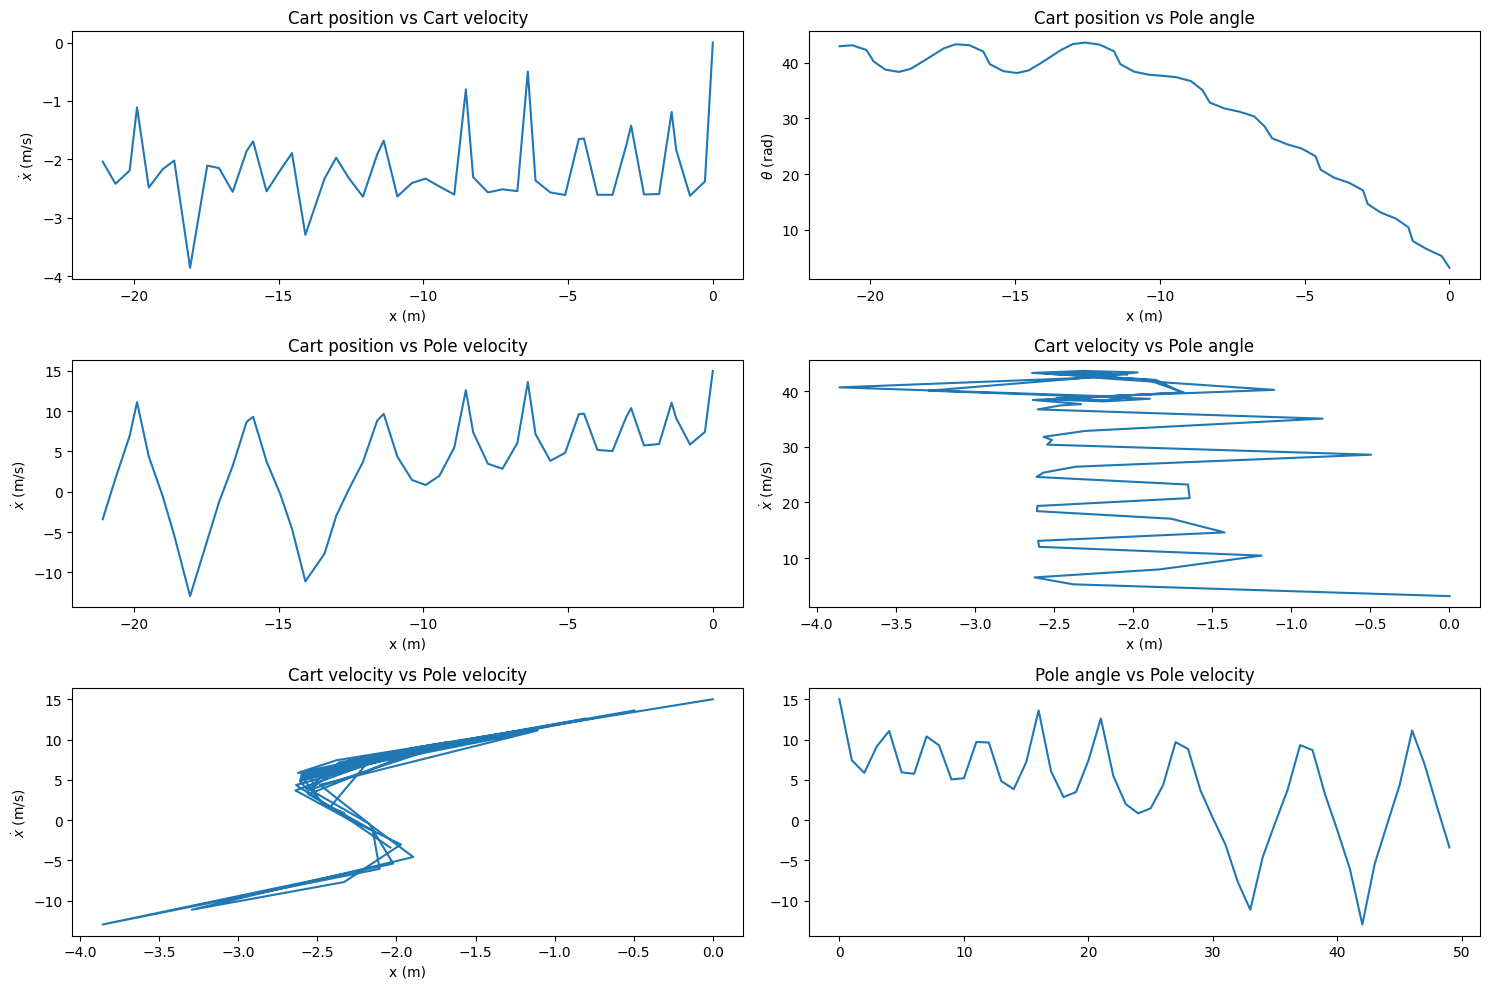

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from CartPole import CartPole

cp = CartPole()

n = 50

initial_state_simple_osc = [0, 0, np.pi, 0.5]
initial_state_complete_rot = [0, 0, np.pi, 15]

# Oscillation around the equilibrium 

def rollout(initial_state):
    cp.setState(initial_state)
    pos = []
    velo = []
    pole_pos = []
    pole_velo = []

    for _ in range(n):
        pos.append(cp.cart_location)
        velo.append(cp.cart_velocity)
        pole_pos.append(cp.pole_angle)
        pole_velo.append(cp.pole_velocity)
        cp.performAction()

    times = np.arange(0,len(pos),1)

    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.plot(times, pos)
    plt.xlabel('Time step')
    plt.ylabel('x (m)')
    plt.title("Cart position")
    plt.subplot(2,2,2)
    plt.plot(times, velo)
    plt.xlabel('Time step')
    plt.ylabel(r'$\dot{x}$ (m/s)')
    plt.title("Cart velocity")
    plt.subplot(2,2,3)
    plt.plot(times, pole_pos)
    plt.xlabel('Time step')
    plt.ylabel(r'$\theta$ (rad)')
    plt.title("Pole angle")
    plt.subplot(2,2,4)
    plt.plot(times, pole_velo)
    plt.xlabel('Time step')
    plt.ylabel(r'$\dot{\theta}$ (rad/s)')
    plt.title("Pole velocity")
    plt.tight_layout()
    plt.show() 

    plt.figure(figsize=(15,10))
    plt.subplot(3,2,1)
    plt.plot(pos, velo)
    plt.title("Cart position vs Cart velocity")
    plt.xlabel("x (m)")
    plt.ylabel(r"$\dot{x}$ (m/s)")
    plt.subplot(3,2,2)
    plt.plot(pos, pole_pos)
    plt.title("Cart position vs Pole angle")
    plt.xlabel("x (m)")
    plt.ylabel(r"$\theta$ (rad)")
    plt.subplot(3,2,3)
    plt.plot(pos, pole_velo)
    plt.title("Cart position vs Pole velocity")
    plt.xlabel("x (m)")
    plt.ylabel(r"$\dot{x}$ (m/s)")
    plt.subplot(3,2,4)
    plt.plot(velo, pole_pos)
    plt.title("Cart velocity vs Pole angle")
    plt.xlabel("x (m)")
    plt.ylabel(r"$\dot{x}$ (m/s)")
    plt.subplot(3,2,5)
    plt.plot(velo, pole_velo)
    plt.title("Cart velocity vs Pole velocity")
    plt.xlabel("x (m)")
    plt.ylabel(r"$\dot{x}$ (m/s)")
    plt.subplot(3,2,6)
    plt.plot(times, pole_velo)
    plt.title("Pole angle vs Pole velocity")
    plt.tight_layout()
    plt.show()


rollout(initial_state_simple_osc)
rollout(initial_state_complete_rot)

### Changes of state

You know from 3F2 that a simple linear controller works for this system, as long as you know where the stationary point is, and have access to the equations of motion so that you can linearise them. But in general, we do not know the equations behind the evolution of a physical system, and so we will take a different approach. What do have are _observations_ of the time evolution of the system. So we will use the simulations like the ones you did above to gather data about the system, and develop a _model_ for this time evolution. 


We will want to build a _model_ for the time evolution of the system. The model is a function $f(X)$ that takes the current state of the system, and maps it onto a new state, which is its prediction for the state at a later time. Let the state of the system be described by a vector X, given by

$$
X = [x, \dot x, \theta, \dot \theta]
$$

Given the current state $X$, let us call $Y$ the state of the system after a single call to the `PerformAction` function (with 0.0 as the force argument, or no argument, which is equivalent). 

#### Task 1.2

To investigate and visualise the functional relationship between $X$ and $Y$, initialise the system using a random value for all state variables, and then scan through one of the state variables in a suitable range (don't forget to reset all the state variables after each call to `PerformAction`), and plot $Y$ as a function of your scan. 

You will observe that the relationship between $X$ and $Y$ as defined above is nearly linear, which is not surprising because the change in one step is small.

We can take account of this and model the _change_ in state vector, rather than taking the new state vector itself as the target of our model. So we define the new target for the modelling as $Y\equiv X(T)-X(0)$, where $X(t)$ represents the time evolution of the state under the dynamics, and T corresponds to a single call to `PerformAction`. Note that in principle we could model changes corresponding arbitrary time shifts, rather than a single call to `PerformAction`, but the longer the time shift, the more complex the model would have to be. 

Explore this new functional relationship again (i) using scans of single variables, and (ii) contour plots where you take slices of the data in two of the variables while you keep the other two variables fixed (the `tricontourf` function of `matplotlib` is very useful). One of the variables has no effect on the next step - which one? 

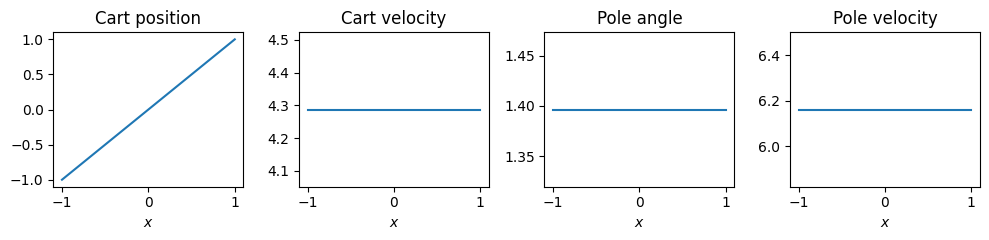

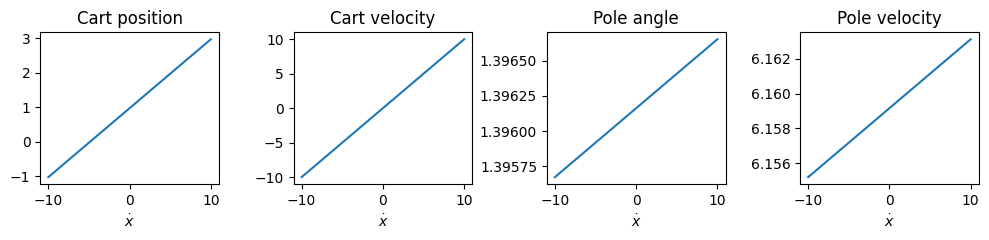

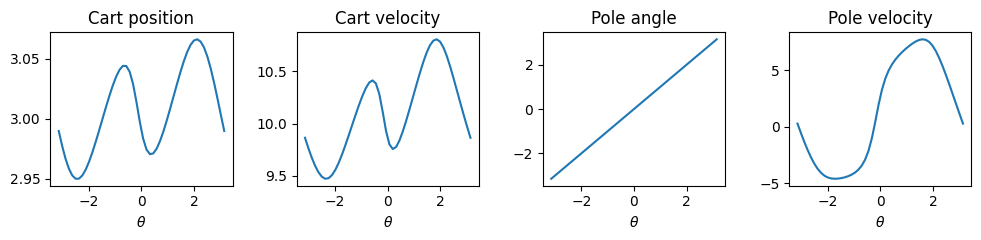

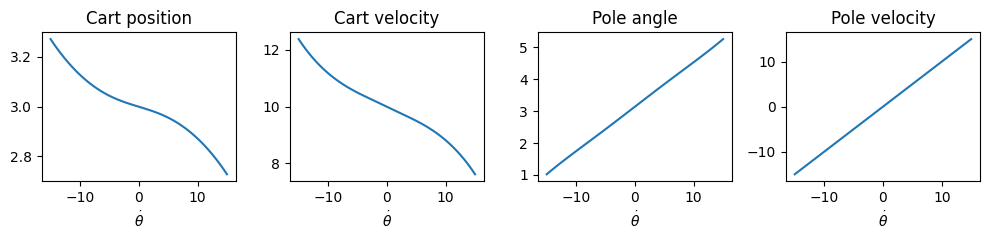

In [2]:
# Y defined here as the output of PerformAction with X as the input

# Using [-10, 10] as suitable range for cart position

cp = CartPole()
n = 50


np.random.seed(0)
c_location = np.random.uniform(-10,10)
c_velocity = np.random.uniform(-10,10)
p_angle = np.random.uniform(-np.pi, np.pi) 
p_velocity = np.random.uniform(-15,15) 
state = [c_location, c_velocity, p_angle, p_velocity]


def sweep1(var):
    l_list = []
    v_list = []
    pa_list = []
    pv_list = []
    cp.setState(state)
    # sweep across cart position
    
    label = 0
    
    if var == 1:
        x_range = np.linspace(-1,1,n)
        for x in x_range:
            state[0] = x
            cp.setState(state)
            cp.performAction()
            l_list.append(state[0])
            v_list.append(cp.cart_velocity)
            pa_list.append(cp.pole_angle)
            pv_list.append(cp.pole_velocity)
            label = r'$x$'
    # sweep across cart velocity
    if var == 2:
        x_range = np.linspace(-10,10,n)
        for x in x_range:
            state[1] = x
            cp.setState(state)
            cp.performAction()
            l_list.append(cp.cart_location)
            v_list.append(state[1])
            pa_list.append(cp.pole_angle)
            pv_list.append(cp.pole_velocity)
            label = r'$\dot{x}$'
    # sweep across pole angle
    if var == 3:
        x_range = np.linspace(-np.pi,np.pi,n)
        for x in x_range:
            state[2] = x
            cp.setState(state)
            cp.performAction()
            l_list.append(cp.cart_location)
            v_list.append(cp.cart_velocity)
            pa_list.append(state[2])
            pv_list.append(cp.pole_velocity)
            label = r'$\theta$'
    # sweep across pole velocity
    if var == 4:
        x_range = np.linspace(-15,15,n)
        for x in x_range:
            state[3] = x
            cp.setState(state)
            cp.performAction()
            l_list.append(cp.cart_location)
            v_list.append(cp.cart_velocity)
            pa_list.append(cp.pole_angle)
            pv_list.append(state[3])
            label = r'$\dot{\theta}$'
    plt.figure(figsize=(10,2.5))
    plt.subplot(1,4,1)
    plt.plot(x_range, l_list)
    plt.xlabel(label)
    plt.title("Cart position")
    plt.subplot(1,4,2)
    plt.plot(x_range,v_list)
    plt.xlabel(label)
    plt.title("Cart velocity")
    plt.subplot(1,4,3)
    plt.plot(x_range,pa_list)
    plt.xlabel(label)
    plt.title("Pole angle")
    plt.subplot(1,4,4)
    plt.plot(x_range, pv_list)
    plt.xlabel(label)
    plt.title("Pole velocity")
    plt.tight_layout()
    plt.show()


sweep1(1)
sweep1(2)
sweep1(3)
sweep1(4)

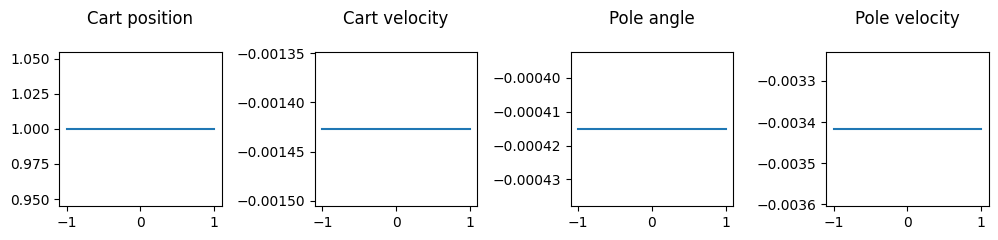

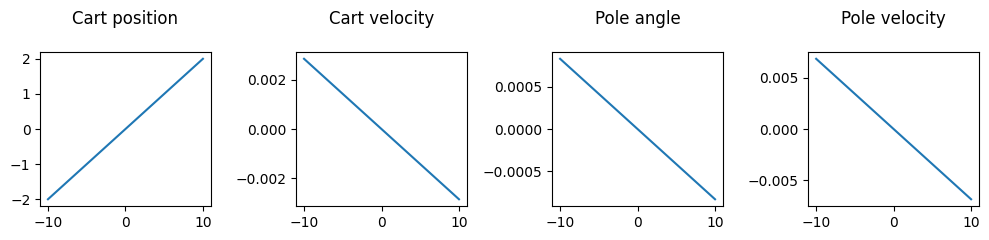

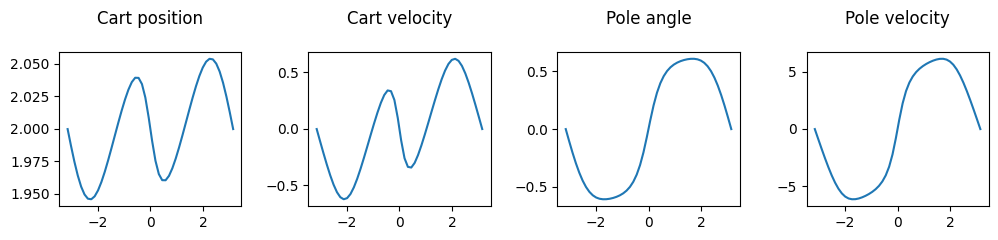

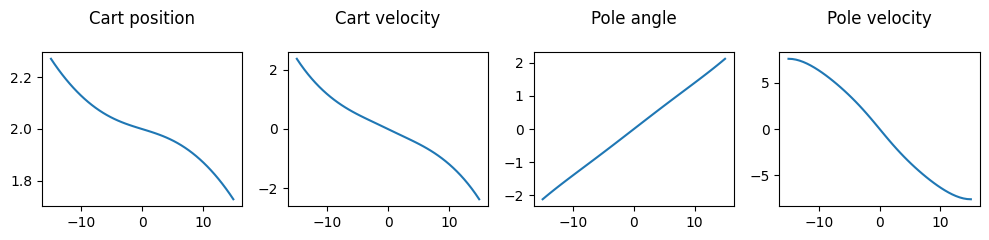

In [3]:
np.random.seed(0)
# c_location = np.random.uniform(-10,10)
# c_velocity = np.random.uniform(-10,10)
# p_angle = np.random.uniform(-np.pi, np.pi) 
# p_velocity = np.random.uniform(-15,15) 
# state = [c_location, c_velocity, p_angle, p_velocity]

state = [0, 5, np.pi, 0]

def sweep2(var):
    l_list = []
    v_list = []
    pa_list = []
    pv_list = []
    cp.setState(state)
    # sweep across cart position
    if var == 1:
        x_range = np.linspace(-1,1,n)
        for x in x_range:
            state[0] = x
            cp.setState(state)
            prev_cl = state[0]
            prev_cv = state[1]
            prev_pl = state[2]
            prev_pv = state[3]
            cp.performAction()
            l_list.append(cp.cart_location - x)
            v_list.append(cp.cart_velocity - prev_cv)
            pa_list.append(cp.pole_angle - prev_pl)
            pv_list.append(cp.pole_velocity - prev_pv)
    # sweep across cart velocity
    if var == 2:
        x_range = np.linspace(-10,10,n)
        for x in x_range:
            state[1] = x
            cp.setState(state)
            prev_cl = state[0]
            prev_cv = state[1]
            prev_pl = state[2]
            prev_pv = state[3]
            cp.performAction()
            l_list.append(cp.cart_location - prev_cl)
            v_list.append(cp.cart_velocity - x)
            pa_list.append(cp.pole_angle - prev_pl)
            pv_list.append(cp.pole_velocity - prev_pv)
    # sweep across pole angle
    if var == 3:
        x_range = np.linspace(-np.pi,np.pi,n)
        for x in x_range:
            state[2] = x
            cp.setState(state)
            prev_cl = state[0]
            prev_cv = state[1]
            prev_pl = state[2]
            prev_pv = state[3]
            cp.performAction()
            l_list.append(cp.cart_location - prev_cl)
            v_list.append(cp.cart_velocity - prev_cv)
            pa_list.append(cp.pole_angle - x)
            pv_list.append(cp.pole_velocity - prev_pv)
    # sweep across pole velocity
    if var == 4:
        x_range = np.linspace(-15,15,n)
        for x in x_range:
            state[3] = x
            cp.setState(state)
            prev_cl = state[0]
            prev_cv = state[1]
            prev_pl = state[2]
            prev_pv = state[3]
            cp.performAction()
            l_list.append(cp.cart_location - prev_cl)
            v_list.append(cp.cart_velocity - prev_cv)
            pa_list.append(cp.pole_angle - prev_pl)
            pv_list.append(cp.pole_velocity - x)
            
    plt.figure(figsize=(10,2.5))
    plt.subplot(1,4,1)
    plt.plot(x_range, l_list)
    plt.title("Cart position", pad=20)
    plt.subplot(1,4,2)
    plt.plot(x_range,v_list)
    plt.title("Cart velocity",pad=20)
    plt.subplot(1,4,3)
    plt.plot(x_range,pa_list)
    plt.title("Pole angle", pad=20)
    plt.subplot(1,4,4)
    plt.plot(x_range, pv_list)
    plt.title("Pole velocity", pad=20)
    plt.tight_layout()
    plt.show()

sweep2(1)
sweep2(2)
sweep2(3)
sweep2(4)

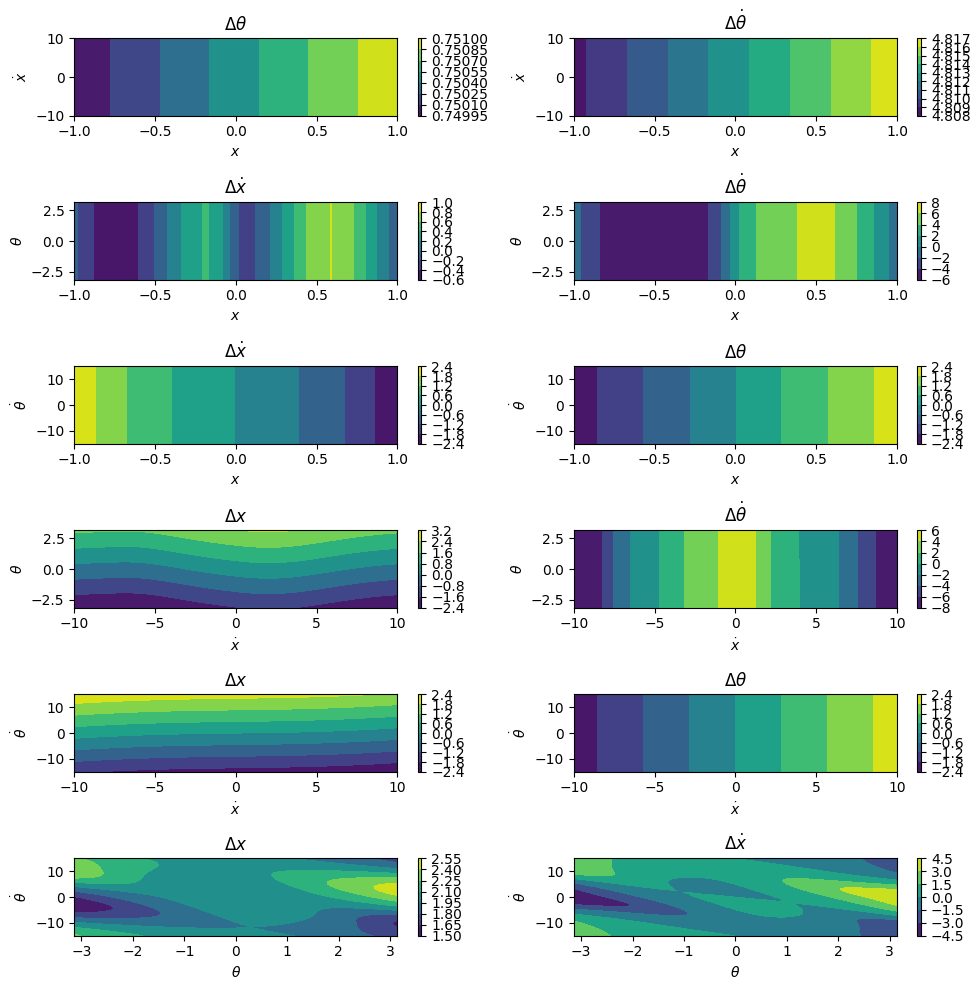

In [4]:
import matplotlib.tri as tri

# List of pairs of meshgrids:
# cl - cv
# cl - pa
# cl - pv
# cv - pa
# cv - pv
# pa - pv

cp = CartPole()
n = 50

c_location = np.random.uniform(-10,10)
c_velocity = np.random.uniform(-10,10)
p_angle = np.random.uniform(-np.pi, np.pi) 
p_velocity = np.random.uniform(-15,15) 
state = [c_location, c_velocity, p_angle, p_velocity]


cl_range = np.linspace(-1,1,50) 
cv_range = np.linspace(-10,10,50)
pa_range = np.linspace(-np.pi,np.pi,50)
pv_range = np.linspace(-15,15,50)


Y_cl_range = np.zeros((50,50))
Y_cv_range = np.zeros((50,50))
Y_pa_range = np.zeros((50,50))
Y_pv_range = np.zeros((50,50))

plt.figure(figsize=(10,10))


# Pair 1: cl - cv

for i, cl in enumerate(cl_range):
    for j, cv in enumerate(cv_range):
        state[0] = cl
        state[1] = cv
        cp.setState(state)
        cp.performAction()
        
        new_state = cp.getState()
        Y_cl_range[i][j] = new_state[0] - state[0]
        Y_cv_range[i][j] = new_state[1] - state[1]
        Y_pa_range[i][j] = new_state[2] - state[2]
        Y_pv_range[i][j] = new_state[3] - state[3]



meshed_cl, meshed_cv = np.meshgrid(cl_range,cv_range)
meshed_cl = meshed_cl.flatten()
meshed_cv = meshed_cv.flatten()
Y_cl_range = Y_cl_range.flatten()
Y_cv_range = Y_cv_range.flatten()
Y_pa_range = Y_pa_range.flatten()
Y_pv_range = Y_pv_range.flatten()
triang_1 = tri.Triangulation(meshed_cl, meshed_cv)


plt.subplot(6,2,1)
plt.tricontourf(triang_1, Y_pa_range)
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')
plt.title(r'$\Delta\theta$')
plt.colorbar()

plt.subplot(6,2,2)
plt.tricontourf(triang_1, Y_pv_range)
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')
plt.title(r'$\Delta \dot{\theta}$')
plt.colorbar()


# Pair 2: cl - pa

Y_cl_range = np.zeros((50,50))
Y_cv_range = np.zeros((50,50))
Y_pa_range = np.zeros((50,50))
Y_pv_range = np.zeros((50,50))
cl_range = np.linspace(-1,1,50) 
cv_range = np.linspace(-10,10,50)
pa_range = np.linspace(-np.pi,np.pi,50)
pv_range = np.linspace(-15,15,50)

for i, cl in enumerate(cl_range):
    for j, pa in enumerate(pa_range):
        state[0] = cl
        state[2] = pa
        cp.setState(state)
        cp.performAction()
        
        new_state = cp.getState()
        Y_cl_range[i][j] = new_state[0] - state[0]
        Y_cv_range[i][j] = new_state[1] - state[1]
        Y_pa_range[i][j] = new_state[2] - state[2]
        Y_pv_range[i][j] = new_state[3] - state[3]



meshed_cl, meshed_pa = np.meshgrid(cl_range,pa_range)
meshed_cl = meshed_cl.flatten()
meshed_pa = meshed_pa.flatten()
Y_cl_range = Y_cl_range.flatten()
Y_cv_range = Y_cv_range.flatten()
Y_pa_range = Y_pa_range.flatten()
Y_pv_range = Y_pv_range.flatten()
triang_2 = tri.Triangulation(meshed_cl, meshed_pa)

plt.subplot(6,2,3)
plt.tricontourf(triang_2, Y_cv_range)
plt.xlabel(r'$x$')
plt.ylabel(r'$\theta$')
plt.title(r'$\Delta \dot{x}$')
plt.colorbar()

plt.subplot(6,2,4)
plt.tricontourf(triang_2, Y_pv_range)
plt.xlabel(r'$x$')
plt.ylabel(r'$\theta$')
plt.title(r'$\Delta \dot{\theta}$')
plt.colorbar()

# Pair 3: cl - pv

Y_cl_range = np.zeros((50,50))
Y_cv_range = np.zeros((50,50))
Y_pa_range = np.zeros((50,50))
Y_pv_range = np.zeros((50,50))
cl_range = np.linspace(-1,1,50) 
cv_range = np.linspace(-10,10,50)
pa_range = np.linspace(-np.pi,np.pi,50)
pv_range = np.linspace(-15,15,50)

for i, cl in enumerate(cl_range):
    for j, pv in enumerate(pv_range):
        state[0] = cl
        state[3] = pv
        cp.setState(state)
        cp.performAction()
        
        new_state = cp.getState()
        Y_cl_range[i][j] = new_state[0] - state[0]
        Y_cv_range[i][j] = new_state[1] - state[1]
        Y_pa_range[i][j] = new_state[2] - state[2]
        Y_pv_range[i][j] = new_state[3] - state[3]



meshed_cl, meshed_pv = np.meshgrid(cl_range,pv_range)
meshed_cl = meshed_cl.flatten()
meshed_pv = meshed_pv.flatten()
Y_cl_range = Y_cl_range.flatten()
Y_cv_range = Y_cv_range.flatten()
Y_pa_range = Y_pa_range.flatten()
Y_pv_range = Y_pv_range.flatten()
triang_3 = tri.Triangulation(meshed_cl, meshed_pv)


plt.subplot(6,2,5)
plt.tricontourf(triang_3, Y_cv_range)
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{\theta}$')
plt.title(r'$\Delta \dot{x}$')
plt.colorbar()


plt.subplot(6,2,6)
plt.tricontourf(triang_3, Y_pa_range)
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{\theta}$')
plt.title(r'$\Delta \theta$')
plt.colorbar()


# Pair 4: cv - pa

Y_cl_range = np.zeros((50,50))
Y_cv_range = np.zeros((50,50))
Y_pa_range = np.zeros((50,50))
Y_pv_range = np.zeros((50,50))
cl_range = np.linspace(-1,1,50) 
cv_range = np.linspace(-10,10,50)
pa_range = np.linspace(-np.pi,np.pi,50)
pv_range = np.linspace(-15,15,50)

for i, cv in enumerate(cv_range):
    for j, pa in enumerate(pa_range):
        state[1] = cv
        state[2] = pa
        cp.setState(state)
        cp.performAction()
        
        new_state = cp.getState()
        Y_cl_range[i][j] = new_state[0] - state[0]
        Y_cv_range[i][j] = new_state[1] - state[1]
        Y_pa_range[i][j] = new_state[2] - state[2]
        Y_pv_range[i][j] = new_state[3] - state[3]


meshed_cv, meshed_pa = np.meshgrid(cv_range,pa_range)
meshed_cv = meshed_cv.flatten()
meshed_pa = meshed_pa.flatten()
Y_cl_range = Y_cl_range.flatten()
Y_cv_range = Y_cv_range.flatten()
Y_pa_range = Y_pa_range.flatten()
Y_pv_range = Y_pv_range.flatten()
triang_4 = tri.Triangulation(meshed_cv, meshed_pa)

plt.subplot(6,2,7)
plt.tricontourf(triang_4, Y_cl_range)
plt.xlabel(r'$\dot{x}$')
plt.ylabel(r'$\theta$')
plt.title(r'$\Delta x$')
plt.colorbar()

plt.subplot(6,2,8)
plt.tricontourf(triang_4, Y_pv_range)
plt.xlabel(r'$\dot{x}$')
plt.ylabel(r'$\theta$')
plt.title(r'$\Delta \dot{\theta}$')
plt.colorbar()

# Pair 5: cv - pv

Y_cl_range = np.zeros((50,50))
Y_cv_range = np.zeros((50,50))
Y_pa_range = np.zeros((50,50))
Y_pv_range = np.zeros((50,50))
cl_range = np.linspace(-1,1,50) 
cv_range = np.linspace(-10,10,50)
pa_range = np.linspace(-np.pi,np.pi,50)
pv_range = np.linspace(-15,15,50)

for i, cv in enumerate(cv_range):
    for j, pv in enumerate(pv_range):
        state[1] = cv
        state[3] = pv
        cp.setState(state)
        cp.performAction()
        
        new_state = cp.getState()
        Y_cl_range[i][j] = new_state[0] - state[0]
        Y_cv_range[i][j] = new_state[1] - state[1]
        Y_pa_range[i][j] = new_state[2] - state[2]
        Y_pv_range[i][j] = new_state[3] - state[3]


meshed_cv, meshed_pv = np.meshgrid(cv_range,pv_range)
meshed_cv = meshed_cv.flatten()
meshed_pv = meshed_pv.flatten()
Y_cl_range = Y_cl_range.flatten()
Y_cv_range = Y_cv_range.flatten()
Y_pa_range = Y_pa_range.flatten()
Y_pv_range = Y_pv_range.flatten()
triang_5 = tri.Triangulation(meshed_cv, meshed_pv)

plt.subplot(6,2,9)
plt.tricontourf(triang_5, Y_cl_range)
plt.xlabel(r'$\dot{x}$')
plt.ylabel(r'$\dot{\theta}$')
plt.title(r'$\Delta x$')
plt.colorbar()

plt.subplot(6,2,10)
plt.tricontourf(triang_5, Y_pa_range)
plt.xlabel(r'$\dot{x}$')
plt.ylabel(r'$\dot{\theta}$')
plt.title(r'$\Delta \theta$')
plt.colorbar()

# Pair 6: pa - pv

Y_cl_range = np.zeros((50,50))
Y_cv_range = np.zeros((50,50))
Y_pa_range = np.zeros((50,50))
Y_pv_range = np.zeros((50,50))
cl_range = np.linspace(-1,1,50) 
cv_range = np.linspace(-10,10,50)
pa_range = np.linspace(-np.pi,np.pi,50)
pv_range = np.linspace(-15,15,50)

for i, pa in enumerate(pa_range):
    for j, pv in enumerate(pv_range):
        state[2] = pa
        state[3] = pv
        cp.setState(state)
        cp.performAction()
        
        new_state = cp.getState()
        Y_cl_range[i][j] = new_state[0] - state[0]
        Y_cv_range[i][j] = new_state[1] - state[1]
        Y_pa_range[i][j] = new_state[2] - state[2]
        Y_pv_range[i][j] = new_state[3] - state[3]


meshed_pa, meshed_pv = np.meshgrid(pa_range,pv_range)
meshed_pa = meshed_pa.flatten()
meshed_pv = meshed_pv.flatten()
Y_cl_range = Y_cl_range.flatten()
Y_cv_range = Y_cv_range.flatten()
Y_pa_range = Y_pa_range.flatten()
Y_pv_range = Y_pv_range.flatten()
triang_6 = tri.Triangulation(meshed_pa, meshed_pv)

plt.subplot(6,2,11)
plt.tricontourf(triang_6, Y_cl_range)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title(r'$\Delta x$')
plt.colorbar()

plt.subplot(6,2,12)
plt.tricontourf(triang_6, Y_cv_range)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title(r'$\Delta\dot{x}$')
plt.colorbar()


plt.tight_layout()
plt.show()

### Linear model


The simplest model is a linear one, where the target $Y$ is assumed to be linear function of the current state $X$,
$$
f(X) = {\bf C} X
$$

where ${\bf C}$ is a $4\times 4$ matrix of coefficients. 

#### Task 1.3

By initialising the simulator in a completely random state (using suitable ranges) and running it for _one_ step, gather
data in the form of pairs of state vectors (X, Y), where X represents a state of the system at step $n$, so $X\equiv X(n)$
and Y represent the change in state after a single call to `performAction` (with zero force), so $Y\equiv X(n+1)-X(n)$. 
Start with 500 data points. 

Using your data set, do linear regression to find the optimal coefficient matrix. Test your predictions against the data. One way to plot the results is to put the input state variable on the horizontal axis and on the vertical axis put the predicted state variable (i.e. what should be the "next step") and the real next step. Another way is to put the target data (i.e. the real "next step") on the horizontal axis and the predicted "next step" on the vertical axis. In this latter plot, a perfect prediction would correspond to a perfect straight line. You should also repeat the "scans" from the previous task, and plot simultaneously the real change in state with your predicted change in state as a function of your scan. Which variables are predicted well by the linear model and which ones are not? Why ? 

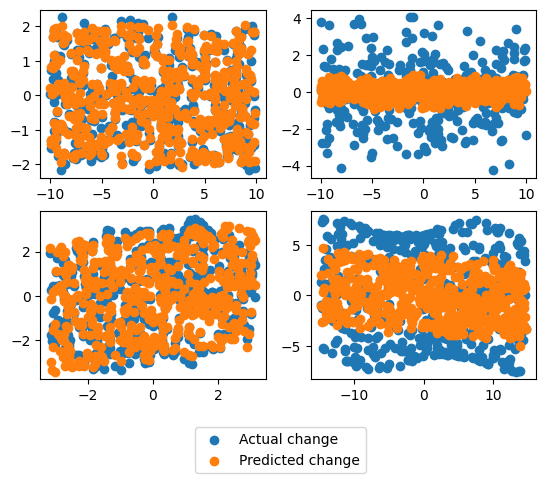

In [5]:
np.random.seed(0)
c_location = np.random.uniform(-10,10)
c_velocity = np.random.uniform(-10,10)
p_angle = np.random.uniform(-np.pi, np.pi) 
p_velocity = np.random.uniform(-15,15)

initial_state = [c_location, c_velocity, p_angle, p_velocity]

cp = CartPole()

no_datapoints = 500


def make_XY_vectors(n, seeds):
    X = []
    low = [-10,-10,-np.pi,-15]
    high = [10,10,np.pi,15]
    for i in range(4):
        np.random.seed(seeds[i])
        X.append(np.random.uniform(low[i], high[i], n))
    X = np.array(X).T
    change_vec_list = []
    next_step_list = []
    for i in range(n):
        x = X[i]
        cp.setState(x)
        cp.performAction()
        new_state = cp.getState()
        y = new_state - x
        change_vec_list.append([x,y])
        next_step_list.append(new_state)
    return np.array(change_vec_list), np.array(next_step_list)


def find_C(vec_list):
    X = np.array([vec[0] for vec in vec_list])
    Y = np.array([vec[1] for vec in vec_list])
    return np.linalg.lstsq(X, Y, rcond=None)[0]


def predict(X, C):
    return np.matmul(X,C)


data_gen_seeds = [1,2,3,4]

XY_vectors, Y_next_step_real_list = make_XY_vectors(no_datapoints, data_gen_seeds)


# X and Y_real_list: both 500 x 4

X = np.array([v[0] for v in XY_vectors])

Y_real_list = np.array([v[1] for v in XY_vectors])


C_opt = find_C(XY_vectors)
Y_pred_list = predict(X, C_opt)

Y_next_step_pred_list = X + Y_pred_list

fig, ax = plt.subplots(2,2)
ax[0,0].scatter(X.T[0], Y_real_list.T[0], label="Actual change") # Cart position actual data
ax[0,0].scatter(X.T[0], Y_pred_list.T[0], label="Predicted change") # Cart position predicted data
ax[0,1].scatter(X.T[1], Y_real_list.T[1], label="Actual change") # Cart position actual data
ax[0,1].scatter(X.T[1], Y_pred_list.T[1], label="Predicted change") # Cart position predicted data
ax[1,0].scatter(X.T[2], Y_real_list.T[2], label="Actual change") # Cart position actual data
ax[1,0].scatter(X.T[2], Y_pred_list.T[2], label="Predicted change") # Cart position predicted data
ax[1,1].scatter(X.T[3], Y_real_list.T[3], label="Actual change") # Cart position actual data
ax[1,1].scatter(X.T[3], Y_pred_list.T[3], label="Predicted change") # Cart position predicted data

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=[0.5,-0.1])

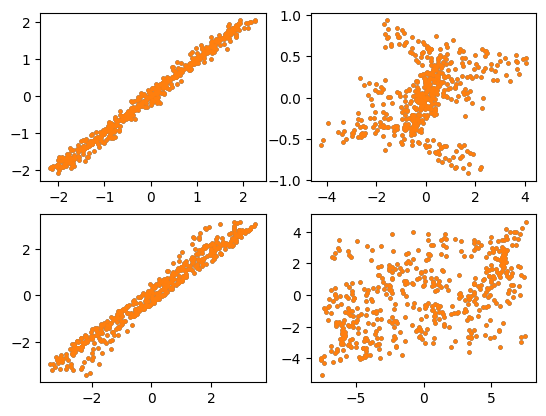

In [6]:
fig, ax = plt.subplots(2,2)
dot_size = 5
ax[0,0].scatter(Y_real_list.T[0], Y_pred_list.T[0], s=dot_size)
ax[0,0].scatter(Y_real_list.T[0], Y_pred_list.T[0], s=dot_size)
ax[0,1].scatter(Y_real_list.T[1], Y_pred_list.T[1], s=dot_size)
ax[0,1].scatter(Y_real_list.T[1], Y_pred_list.T[1], s=dot_size)
ax[1,0].scatter(Y_real_list.T[2], Y_pred_list.T[2], s=dot_size)
ax[1,0].scatter(Y_real_list.T[2], Y_pred_list.T[2], s=dot_size)
ax[1,1].scatter(Y_real_list.T[3], Y_pred_list.T[3], s=dot_size)
ax[1,1].scatter(Y_real_list.T[3], Y_pred_list.T[3], s=dot_size)

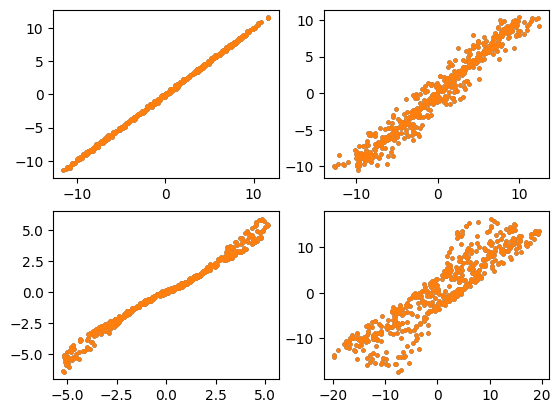

In [7]:
fig, ax = plt.subplots(2,2)
dot_size = 5

ax[0,0].scatter(Y_next_step_real_list.T[0], Y_next_step_pred_list.T[0], s=dot_size)
ax[0,0].scatter(Y_next_step_real_list.T[0], Y_next_step_pred_list.T[0], s=dot_size)
ax[0,1].scatter(Y_next_step_real_list.T[1], Y_next_step_pred_list.T[1], s=dot_size)
ax[0,1].scatter(Y_next_step_real_list.T[1], Y_next_step_pred_list.T[1], s=dot_size)
ax[1,0].scatter(Y_next_step_real_list.T[2], Y_next_step_pred_list.T[2], s=dot_size)
ax[1,0].scatter(Y_next_step_real_list.T[2], Y_next_step_pred_list.T[2], s=dot_size)
ax[1,1].scatter(Y_next_step_real_list.T[3], Y_next_step_pred_list.T[3], s=dot_size)
ax[1,1].scatter(Y_next_step_real_list.T[3], Y_next_step_pred_list.T[3], s=dot_size)

STATE: [0.9762700785464951, 4.30378732744839, 0.6456813346495229, 1.346495489906907]


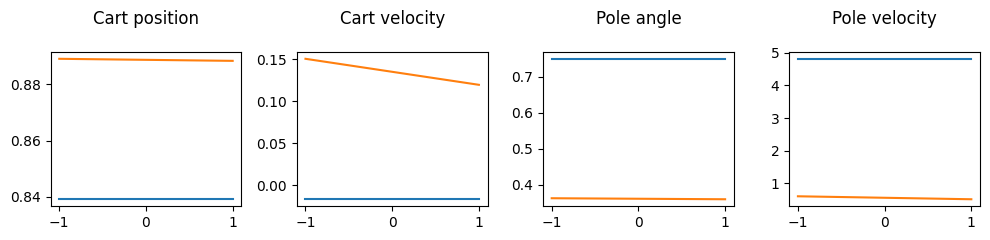

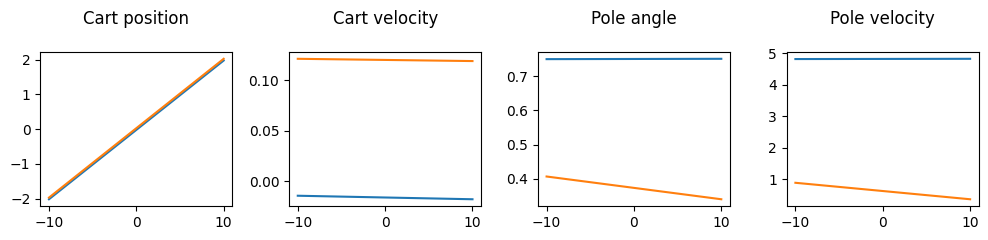

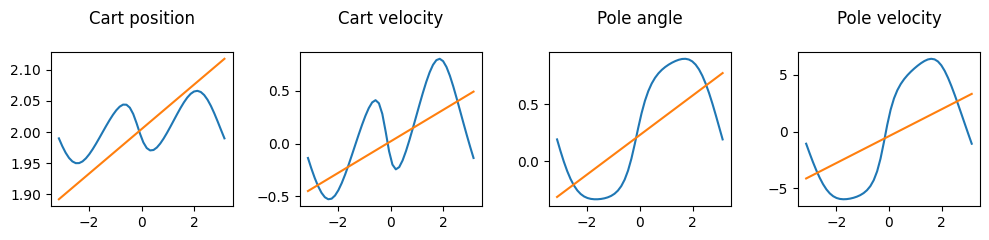

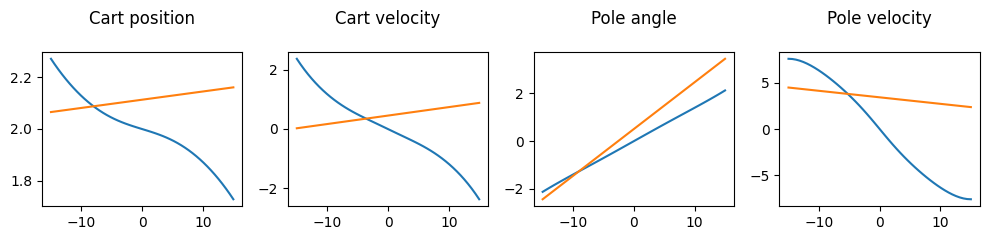

In [8]:
np.random.seed(0)
c_location = np.random.uniform(-10,10)
c_velocity = np.random.uniform(-10,10)
p_angle = np.random.uniform(-np.pi, np.pi) 
p_velocity = np.random.uniform(-15,15) 
initial_state = [c_location, c_velocity, p_angle, p_velocity]

print("STATE:", initial_state)

def sweep2(var):
    state = initial_state
    X = []

    l_list = []
    v_list = []
    pa_list = []
    pv_list = []

    # sweep across cart position
    if var == 1:
        x_range = np.linspace(-1,1,n)
        for i in range(n):
            state[0] = x_range[i]
            X.append(state.copy())
            cp.setState(state)
            cp.performAction()
            new_state = [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity]
            l_list.append(new_state[0] - state[0])
            v_list.append(new_state[1] - state[1])
            pa_list.append(new_state[2] - state[2])
            pv_list.append(new_state[3] - state[3])
        X = np.array(X)
        Y_pred_list = predict(X, C_opt)

    # sweep across cart velocity
    if var == 2:
        x_range = np.linspace(-10,10,n)
        for i in range(n):
            state[1] = x_range[i]
            X.append(state.copy())
            cp.setState(state)
            prev_cl = state[0]
            prev_cv = state[1]
            prev_pl = state[2]
            prev_pv = state[3]
            cp.performAction()
            new_state = [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity]
            l_list.append(cp.cart_location - prev_cl)
            v_list.append(cp.cart_velocity - x_range[i])
            pa_list.append(cp.pole_angle - prev_pl)
            pv_list.append(cp.pole_velocity - prev_pv)
        X = np.array(X)
        Y_pred_list = predict(X, C_opt)

    # sweep across pole angle
    if var == 3:
        x_range = np.linspace(-np.pi,np.pi,n)
        for i in range(n):
            state[2] = x_range[i]
            X.append(state.copy())
            cp.setState(state)
            cp.performAction()
            new_state = [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity]
            l_list.append(cp.cart_location - state[0])
            v_list.append(cp.cart_velocity - state[1])
            pa_list.append(cp.pole_angle - state[2])
            pv_list.append(cp.pole_velocity - state[3])
        X = np.array(X)
        Y_pred_list = predict(X, C_opt)


    # sweep across pole velocity
    if var == 4:
        x_range = np.linspace(-15,15,n)
        for i in range(n):
            state[3] = x_range[i]
            X.append(state.copy())
            cp.setState(state)
            prev_cl = state[0]
            prev_cv = state[1]
            prev_pl = state[2]
            prev_pv = state[3]
            cp.performAction()
            new_state = [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity]
            l_list.append(cp.cart_location - prev_cl)
            v_list.append(cp.cart_velocity - prev_cv)
            pa_list.append(cp.pole_angle - prev_pl)
            pv_list.append(cp.pole_velocity - x_range[i])
        X = np.array(X)
        Y_pred_list = predict(X, C_opt)
    
    plt.figure(figsize=(10,2.5))
    plt.subplot(1,4,1)
    plt.plot(x_range, l_list)
    plt.plot(x_range, Y_pred_list.T[0])
    plt.title("Cart position", pad=20)
    plt.subplot(1,4,2)
    plt.plot(x_range,v_list)
    plt.plot(x_range, Y_pred_list.T[1])
    plt.title("Cart velocity",pad=20)
    plt.subplot(1,4,3)
    plt.plot(x_range,pa_list)
    plt.plot(x_range, Y_pred_list.T[2])
    plt.title("Pole angle", pad=20)
    plt.subplot(1,4,4)
    plt.plot(x_range, pv_list)
    plt.plot(x_range, Y_pred_list.T[3])
    plt.title("Pole velocity", pad=20)
    plt.tight_layout()
    plt.show()

sweep2(1)
sweep2(2)
sweep2(3)
sweep2(4)

#### Task 1.4

The true test of the model is not how it matches with the gathered data it was fit to, but whether it can predict the time evolution of the physical system. Iterate the model to predict the time evolution of the system, and compare using various initial conditions how accurate the predictions are with respect to the true dynamics started from the same initial conditions. (Note that the model is being used deterministically, with no noise added)

Since your models above predict the _change_ in the state variable, the iterated time evolution is
$$
X_{n+1} \leftarrow X_n + f(X_n)
$$

Plot the true time evolution of the system as well as that of your fitted models for many cycles, and for different initial conditions, including ones where the pole makes a full circle. 

_Angle range_ If you leave the angle without remapping, your solution with the iterated model will diverge. Why is that? Ensure that you remap the angle during the above iterations. (Note how remapping is not needed in the true dynamics, since that is nonlinear, and the angle only appears inside trigonometric functions that are periodic anyway).

In [9]:

initial_state_linear = [0, 5, np.pi, 0]
initial_state_simple_osc = [0, 0, np.pi, 0.5]
initial_state_complete_rot = [0, 0, np.pi, 15]


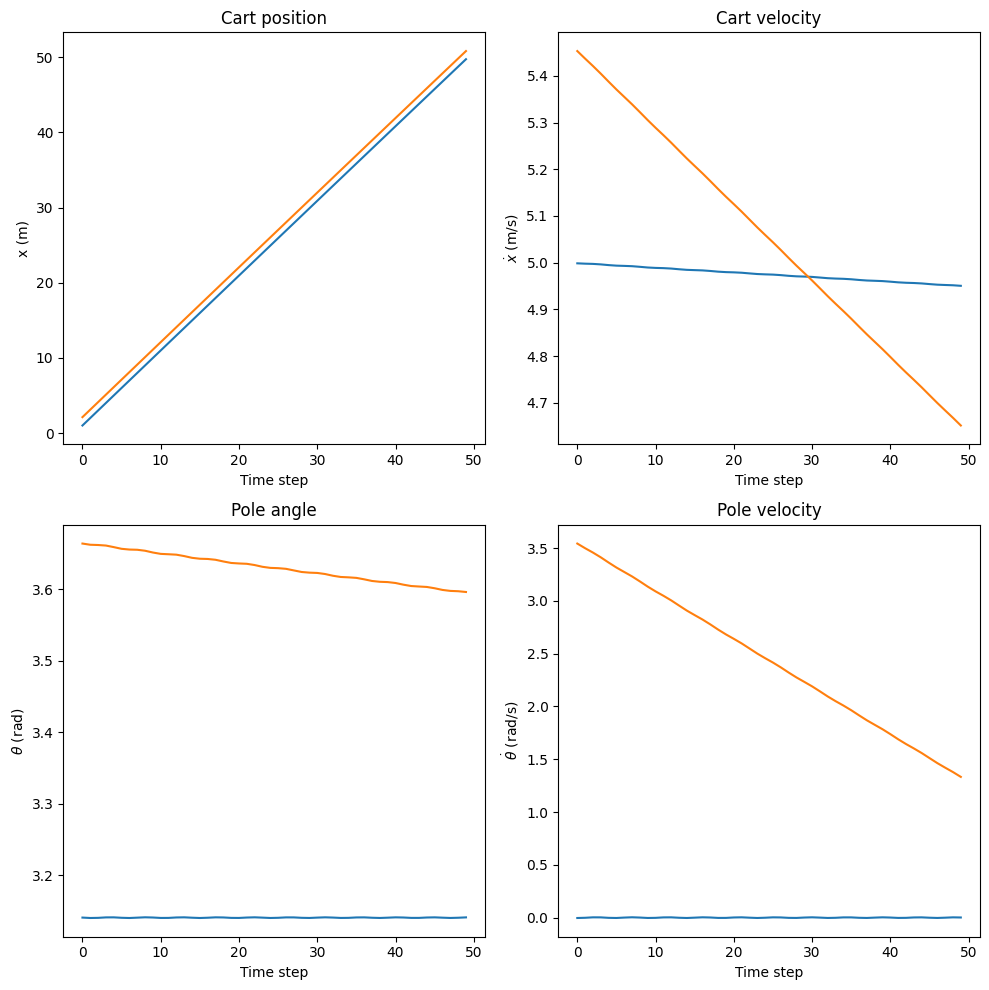

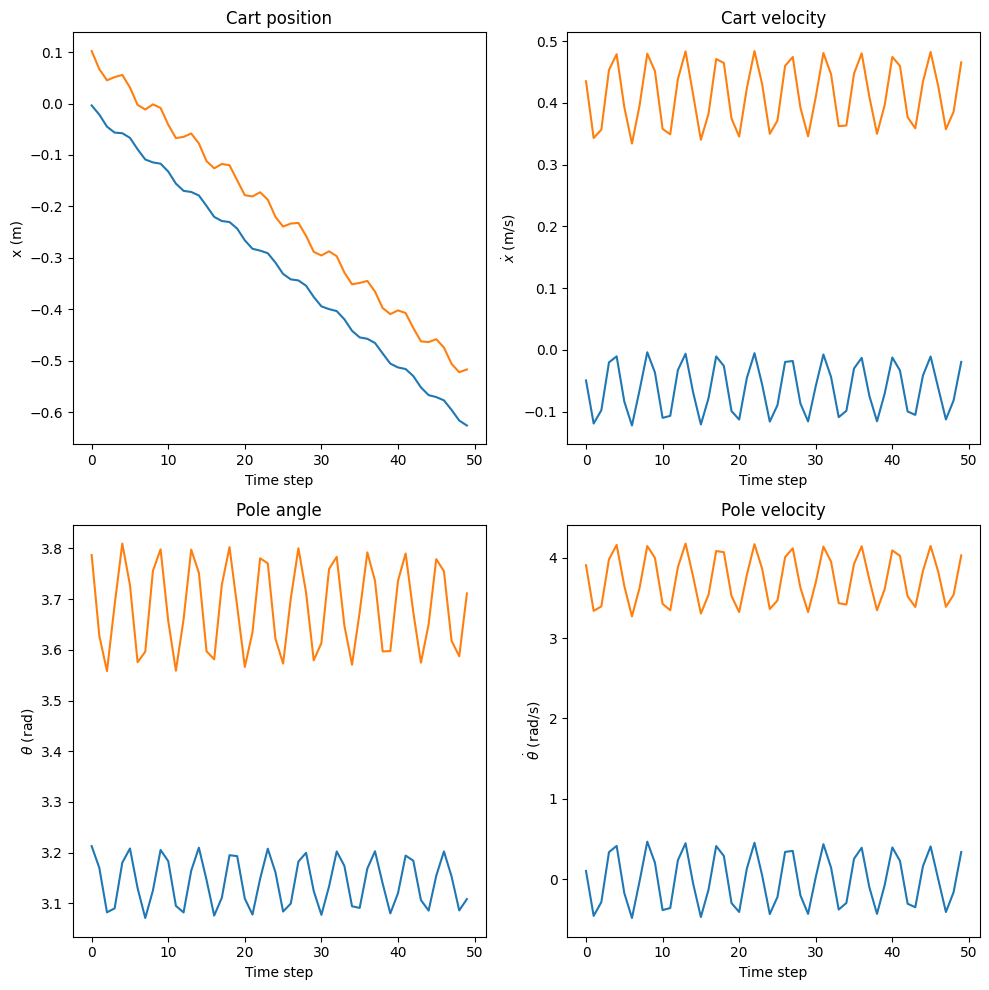

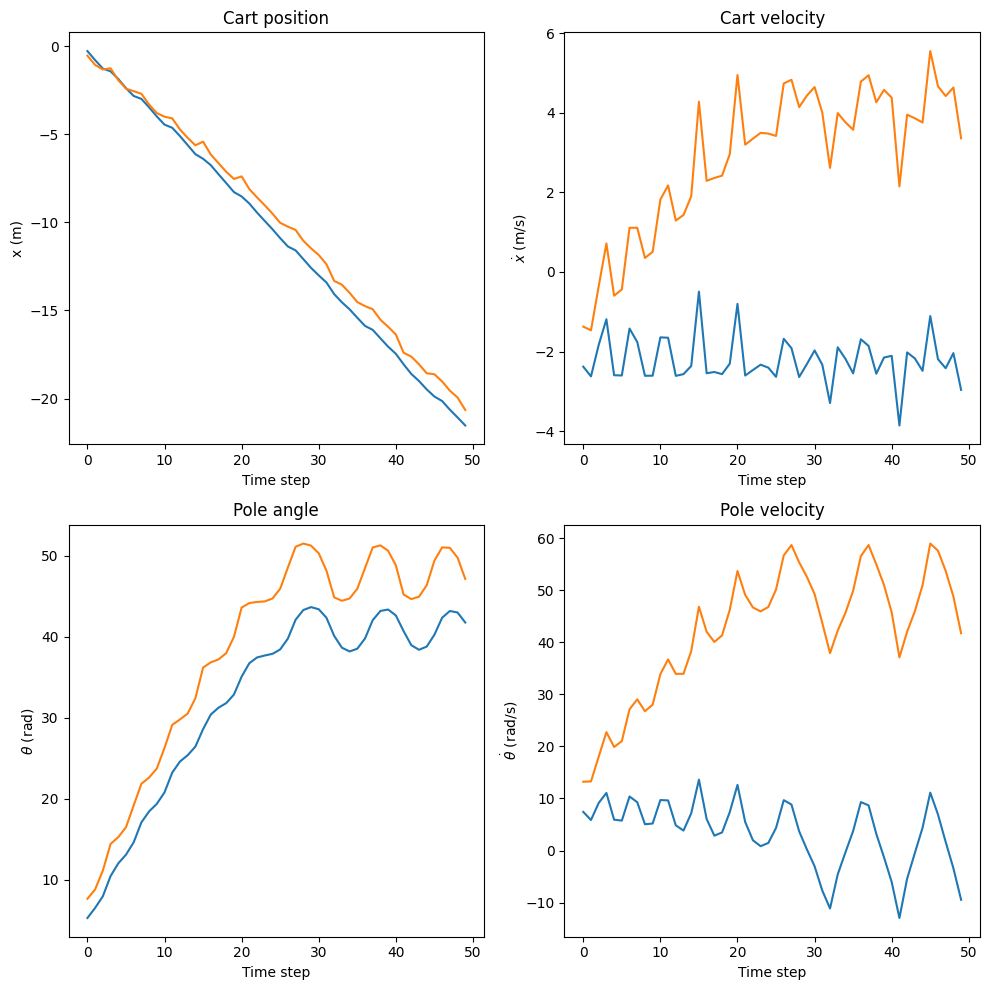

In [10]:
def test_prediction(initial_state, remap):
    cp.setState(initial_state)
    pred_state_list = []
    l_list = []
    v_list = []
    pa_list = []
    pv_list = []

    for _ in range(n):
        cp.performAction()
        if remap == True:
            cp.remap_angle()
        state = np.array([cp.cart_location,cp.cart_velocity, cp.pole_angle, cp.pole_velocity])
        l_list.append(state[0])   
        v_list.append(state[1])  
        pa_list.append(state[2])    
        pv_list.append(state[3]) 
        pred_state_list.append(np.matmul(state, C_opt) + state)
    
    times = np.arange(0,n,1)
    pred_state_list = np.array(pred_state_list)

    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.plot(times, l_list)
    plt.plot(times, pred_state_list.T[0])
    plt.xlabel('Time step')
    plt.ylabel('x (m)')
    plt.title("Cart position")
    plt.subplot(2,2,2)
    plt.plot(times, v_list)
    plt.plot(times, pred_state_list.T[1])
    plt.xlabel('Time step')
    plt.ylabel(r'$\dot{x}$ (m/s)')
    plt.title("Cart velocity")
    plt.subplot(2,2,3)
    plt.plot(times, pa_list)
    plt.plot(times, pred_state_list.T[2])
    plt.xlabel('Time step')
    plt.ylabel(r'$\theta$ (rad)')
    plt.title("Pole angle")
    plt.subplot(2,2,4)
    plt.plot(times, pv_list)
    plt.plot(times, pred_state_list.T[3])
    plt.xlabel('Time step')
    plt.ylabel(r'$\dot{\theta}$ (rad/s)')
    plt.title("Pole velocity")
    plt.tight_layout()
    plt.show()


test_prediction(initial_state_linear, remap=False)
test_prediction(initial_state_simple_osc, remap=False)
test_prediction(initial_state_complete_rot, remap=False)
    
     

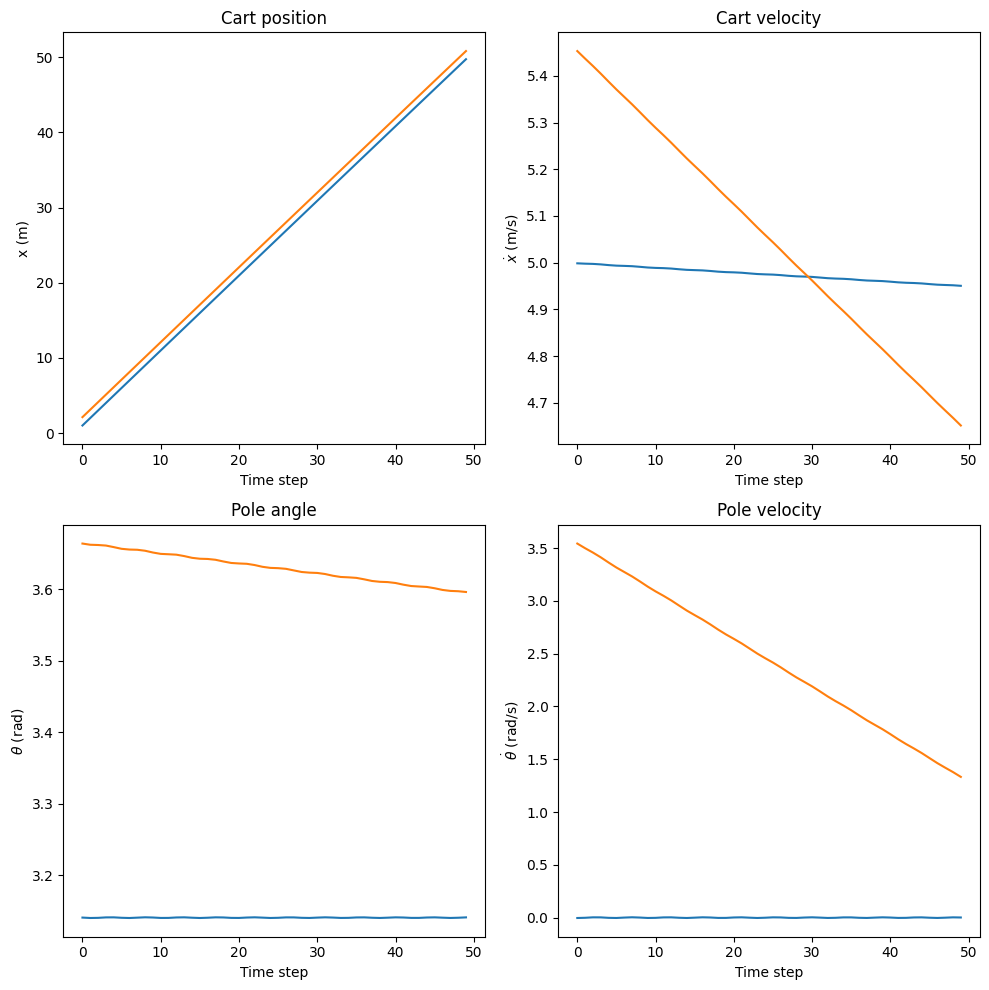

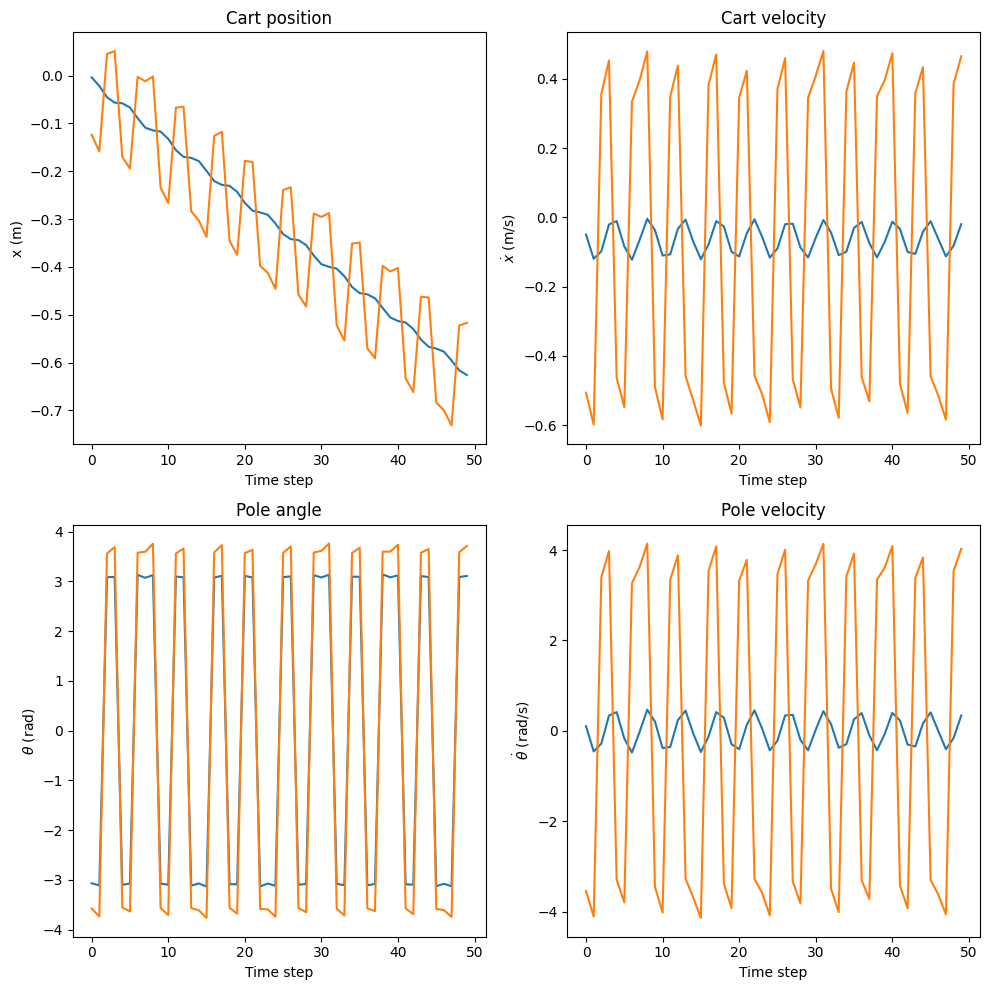

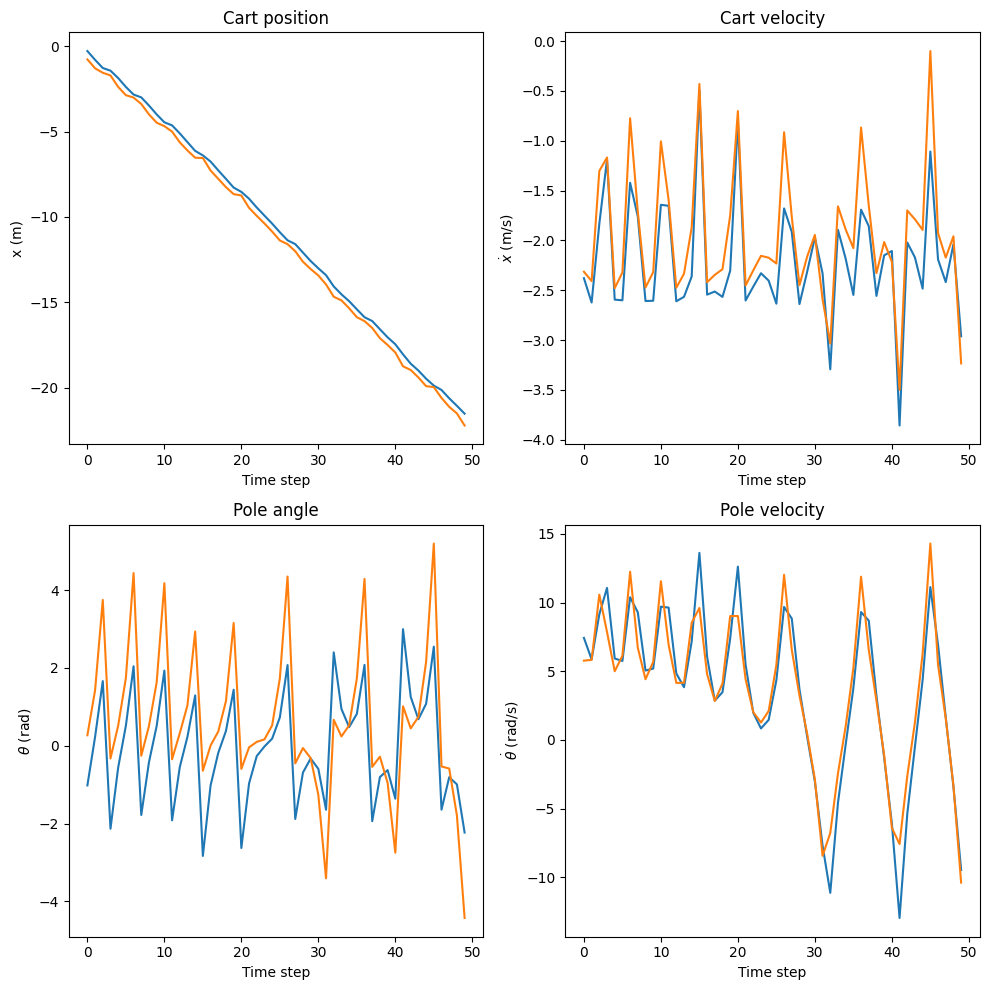

In [11]:
test_prediction(initial_state_linear, remap=True)
test_prediction(initial_state_simple_osc, remap=True)
test_prediction(initial_state_complete_rot, remap=True)

## Week 2

### Nonlinear model
As you observed above, the linear model is not particularly good. In order to do better, we need nonlinear modelling. Next you are going to do build a nonlinear model using a linear regression with nonlinear basis functions. Given a data set of (X,Y) pairs, the model function is given by

$$
f(X) = \sum_i \alpha_i K(X, X_i)
$$

where the sum runs over the basis functions, $\alpha_i$ are the corresponding coefficients, and $K$ is a _kernel function_ that is used to define the nonlinear basis. The kernel function takes two arguments, the first one $X$ is the state vector where you evaluate the basis function, and the second argument, $X_i$ is another state vector which we use to place the basis function somewhere in the state space. To make the basis functions relevant, we take the set of locations $\{X_i\}$ to be a subset of the gathered data points.  

For the present problem, let us use a Gaussian kernel function,

$$
K(X,X') = e^{-\sum_j \frac{\left(X^{(j)}-X'^{(j)}\right)^2}{2\sigma_j^2}}
$$

Here $X^{(j)}$ refers to the $j$th component of the state vector. There is one caveat for using this kernel function in our
current situation: one of our state vector components, $\theta$ is periodic. It helps quite a bit if we introduce this
periodicity in our kernel function, and we can do that by using $\sin^2\left( (\theta - \theta')/2 \right)$ in place
of $\left(\theta -\theta' \right)^2$ in the part of the kernel function that corresponds to the angle variable. The parameters
$\sigma_j$ are _length scale_ hyperparameters of the model, and need to be known, guessed or fitted. 



If we have $N$ data locations (each is an (X,Y) pair but remember that here X is a vector and Y is a scalar), substituting this data into
the model functional form yields the following linear system

$$
K_{NN} \alpha_N = Y_N
$$

where the subscript $N$ was used to emphasize the size of the array rather than an index. The unknown coefficients are collected
into the vector $\alpha_N$, the elements of the matrix are given by the kernel function, 

$$
[K_{NN}]_{i,i'} = K(X_i,X_{i'})
$$

and $Y_N$ is a vector of the target function values. With Gaussian basis functions, the condition number of the matrix is enormous, and a direct solution of the above linear system would be
rather unstable. One way to get around this is to _regularise_ the linear system. Tikhonov regularisation is to modify it to 

$$
(K_{NN} + \lambda I) \alpha_N = Y_N
$$
with solution
$$
\alpha_N = [K_{NN} + \lambda I]^{-1} Y_N
$$

where $\lambda$ is a parameter. The smaller the values of $\lambda$, the closer is the fit to the data, but the more unstable
the linear system. Interestingly, this is also exactly the form of the (mean) solution in the Gaussian process regression problem of
inference in the presence of noisy input data, with the identification that $\lambda$ is the variance of the data noise. 

Suppose we collected $N$ pairs of $(X,Y)$ data pairs, and we choose a subset $M$ of the $X$ locations to serve as basis function centres.
The linear system is then not square:
$$
K_{NM} \alpha_M = Y_N
$$
where again the subscripts indicate dimensions, $K_{MN}$ is an $M \times N$ matrix with elements corresponding to the $M$ basis locations
and all the $N$ data point locations. We have fewer unknown coefficients than data points, so the problem is over-determined. 
The least squares solution would be
$$
\alpha_M = [K_{MN} K_{NM}]^{-1} K_{MN} Y_N
$$
i.e. using the pseudoinverse rather than the inverse. The matrix in square brackets will in general be uninvertible or very badly 
conditioned, so again we need to regularise. Interestingly, rather just adding a multiple of the identity matrix like in the
square case, we can look to Gaussian process inference for a better idea. It turns out that a _sparse Gaussian process_ precisely
corresponds to this case. There, the model is written as a conditional probability not on the original $N$ data values directly, but on the
unknown function values at the $M$ data locations that are chosen for the basis function centers. The vector of linear coefficients of
the fitted model are then given by 

$$
\alpha^{(j)}_M = \left(K_{MN}K_{NM} + \lambda K_{MM} \right)^{-1} K_{MN}  Y_N^{(j)}
$$

where $K_{MM}$ is an $M \times M$ matrix with elements that are given by the kernel function evaluated between the locations
selected as basis locations. The interpretation of this is that the least squares system is Tikhonov regularised but the regulariser
is evaluated in the kernel-norm, rather than the Euclidean norm. 


#### Task 2.1

Fit a model of the system using the data you gathered earlier. Your target function could be either again the change in
state after one step as before, or the _error of your linear model_ in the change in state. Verify using scatterplots that
the nonlinear model indeed fits the data. Study the convergence of the model (i.e. the systematic reduction in error) as a
function of increasing data amount, and the increasing number of basis functions (e.g. start with $M=10$ and increase by
factors of 2, select the data locations for the basis randomly from the data). Also plot 2D slices of your target function
and the fit, as well as do roll-outs to see how closely the iterated model matches the real dynamics for a wide range of
sensible initial conditions. How long does your model show reasonable agreement with the real dynamics? Quantify this in units of time
and also in the number of oscillation cycles. How does this correlate with the pointwise accuracy you measure on random test data? 

An alternative to random data locations is to use _quasirandom sequences_, these provide a set of locations in an arbitrary dimensional unit cube that are "nicely" spaced out for sampling, better than random draws. You can use the `sobol_seq` module to generate such locations (read the on-line example, but each new location is obtained with a call to the `vec, seed = sobol_seq.i4_sobol(4, seed)` function for 4 dimensions, with the seed provided by the previous call)

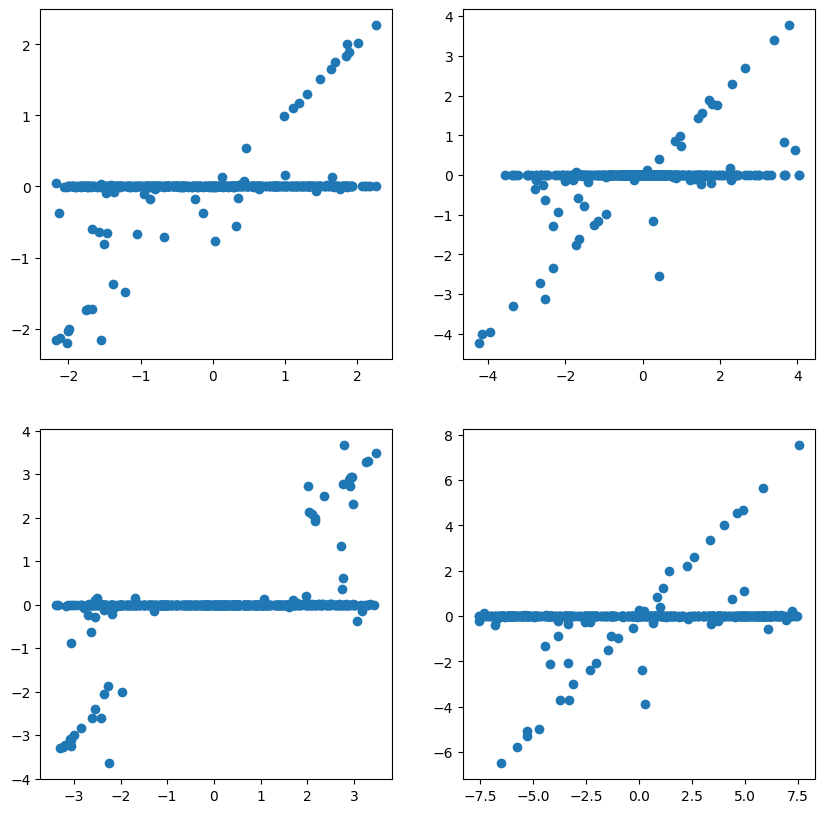

In [25]:
# N = 500: 500 datapoints

def calculate_kernel(X, X_prime, sig):
    K = np.zeros((len(X), len(X_prime)))
    for i in range(len(X)):
        for j in range(len(X_prime)):
            exp_cl = (X[i][0] - X_prime[j][0])**2 / (2*sig[0]**2)
            exp_cv = (X[i][1] - X_prime[j][1])**2 / (2*sig[1]**2)
            exp_pa = np.sin((X[i][2] - X_prime[j][2])/2)**2 / (2*sig[2]**2)
            exp_pv = (X[i][3] - X_prime[j][3])**2 / (2*sig[3]**2)
            exponent = exp_cl + exp_cv + exp_pa + exp_pv
            K[i][j] = np.exp(exponent)
    return K

def nonlinear_model(XY, M, sig, lmda):
    X = np.array([vec[0] for vec in XY])
    Y = np.array([vec[1] for vec in XY])
    X_prime_indices = np.random.choice(len(X), size=M, replace=False, p=None)
    X_prime = X[X_prime_indices]
    K_NM = calculate_kernel(X, X_prime, sig)
    K_MM = calculate_kernel(X_prime, X_prime, sig)
    K_MN = K_NM.T
    a = np.matmul(K_MN, K_NM) + lmda * K_MM
    b = K_MN @ Y
    alpha_M = np.linalg.lstsq(a, b, rcond=None)[0]
    return alpha_M, X_prime_indices, Y

# Run the model
M = 500  # The number of basis functions
sig = [3,3,1,3]  # The scale factors for the four state variables respectively
lmda = 0.1  # The variance of the data noise
alpha_M, X_prime_indices, Y = nonlinear_model(XY_vectors, M, sig, lmda)

# Use the model for prediction
X = np.array([vec[0] for vec in XY_vectors])
X_prime = X[X_prime_indices]
K_NM = calculate_kernel(X, X_prime, sig)


Y_pred = K_NM @ alpha_M


# Scatter plot of predicted state against actual state 

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(Y.T[0], Y_pred.T[0])
ax[0,1].scatter(Y.T[1], Y_pred.T[1])
ax[1,0].scatter(Y.T[2], Y_pred.T[2])
ax[1,1].scatter(Y.T[3], Y_pred.T[3])
plt.show()

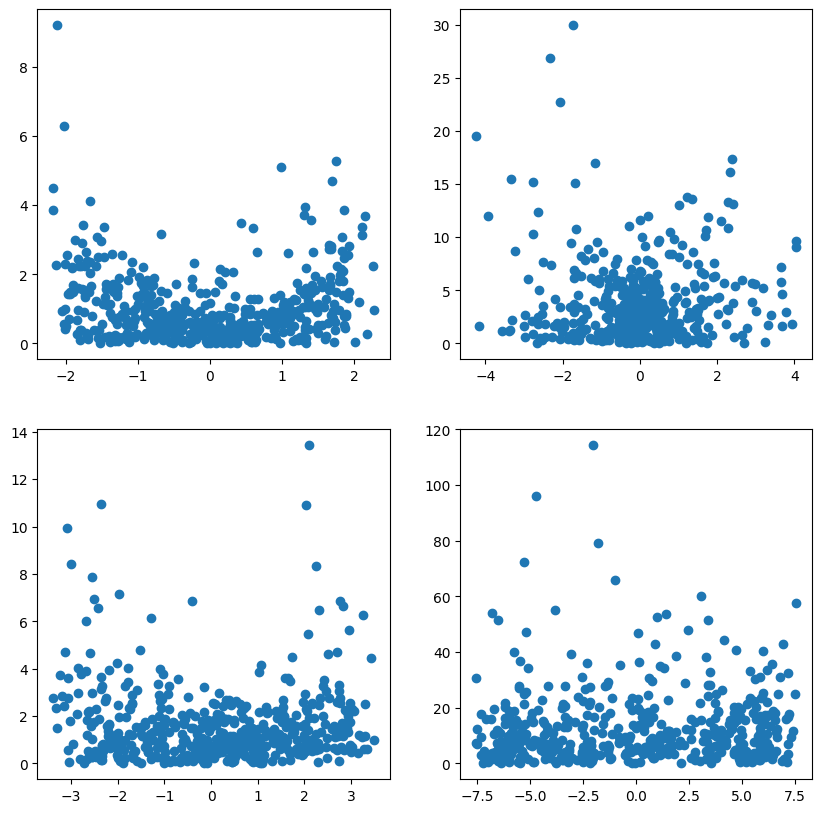

In [13]:
# Set target function to Y_pred - Y_actual, and plot:

# the Y column in XY_vectors is the actual change in state
# Y_pred from the above cell is the predicted change in state

pred_err = abs(Y-Y_pred)  # Prediction error

# Scatter plots of Y against prediction error
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(Y.T[0], pred_err.T[0]) 
ax[0,1].scatter(Y.T[1], pred_err.T[1])
ax[1,0].scatter(Y.T[2], pred_err.T[2])
ax[1,1].scatter(Y.T[3], pred_err.T[3])
plt.show()

[ 0.25463853  1.71134757  0.56015132 19.43390746]
[ 0.21702573  1.71899496  0.77389536 19.02485111]
[ 0.14018544  1.73551795  0.65876128 18.95750837]
[ 0.28808592  1.77940488  0.57659457 19.34777183]
[ 0.37337458  1.75984296  0.7237419  19.22114016]


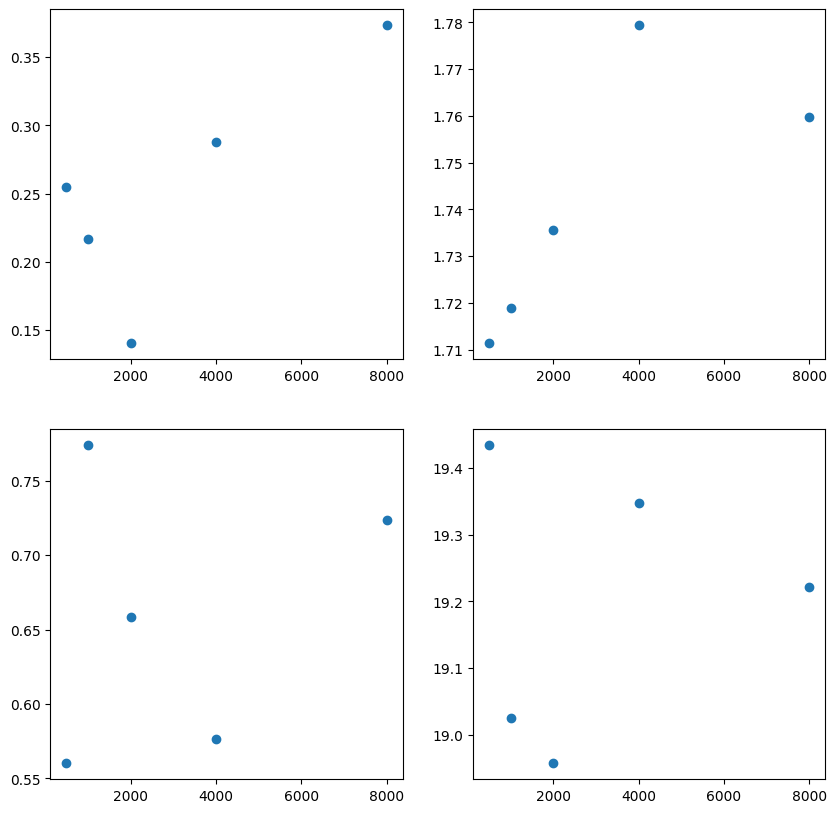

In [14]:
# Plotting mean squared error as a function of N, with M = 10

# Test for N = 500, 1000, 2000, 4000, 8000

mse = []
n_list = [500, 1000, 2000, 4000, 8000]

for n_dp in n_list:
    XY_vec, _ = make_XY_vectors(n_dp, data_gen_seeds)
    
    alpha_M, X_prime_indices, Y = nonlinear_model(XY_vec, 10, sig, lmda)
    
    # Use the model for prediction
    X = np.array([vec[0] for vec in XY_vec])
    X_prime = X[X_prime_indices]
    K_NM = calculate_kernel(X, X_prime, sig)  
    
    Y_pred = K_NM @ alpha_M
    
    err = np.square(Y_pred - Y).mean(axis=0)
    print(err)
    mse.append(err)

mse = np.array(mse)
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(n_list, mse.T[0]) 
ax[0,1].scatter(n_list, mse.T[1])
ax[1,0].scatter(n_list, mse.T[2])
ax[1,1].scatter(n_list, mse.T[3])
plt.show()

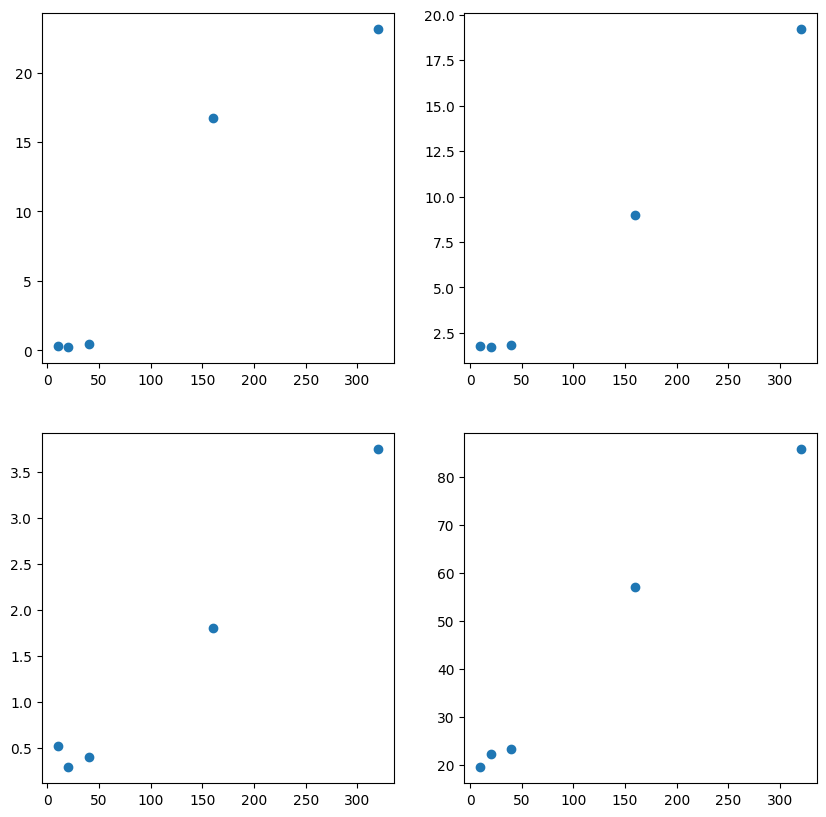

In [15]:
# Plotting mean squared error as a function of M, for N fixed at 500

mse = []
m_list = [10,20,40,160,320]

for m in m_list:
    # Here we are using XY_vectors, the array with 500 datapoints generated previously
    
    alpha_M, X_prime_indices, Y = nonlinear_model(XY_vectors, m, sig, lmda=20)

    # Use the model for prediction
    X = np.array([vec[0] for vec in XY_vectors])
    X_prime = X[X_prime_indices]
    K_NM = calculate_kernel(X, X_prime, sig)  
    
    Y_pred = K_NM @ alpha_M
    
    err = np.square(Y_pred - Y).mean(axis=0)
    mse.append(err)

mse = np.array(mse)
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(m_list, mse.T[0]) 
ax[0,1].scatter(m_list, mse.T[1])
ax[1,0].scatter(m_list, mse.T[2])
ax[1,1].scatter(m_list, mse.T[3])
plt.show()

## Control

Having developed a good model for the dynamics, now it is time to control the system. In this exercise we will create a controller
to achieve a desired state by parametrising the actions of the controller, and optimising those parameters through evaluation of
the performance. This is called _reinforcement learning_ in general. Using the interaction of the controller with the system
to improve it is "direct policy search". There are many other, more sophisticated strategies.  

When you call the `performAction` routine, it takes a signed scalar which is interpreted as an external force on the cart. The value is passed through the `tanh` function 
before being interpreted as a force, this prevents the application of excessively large forces (the transformation is controlled
by the `max_force` variable inside the `CartPole` class.) The first thing you will need do is to modify your models (both the linear and nonlinear) to take account of this new state 
variable (i.e. your system now has 5 inputs, including the force F, and 4 outputs after a call to `performAction`). 

#### Task 2.2
Change your code so that the state vector now includes the action taken. Collect new data, again using random initial conditions or quasi-random sequences and one step, but this time include the action. Verify using scatter-plots, 1D and 2D scans and roll-outs that your models can predict the change in the state variables.  

In [16]:
def make_XY_vectors_wforce(n, seeds, f):
    X = []
    low = [-10,-10,-np.pi,-15]
    high = [10,10,np.pi,15]
    for i in range(4):
        np.random.seed(seeds[i])
        X.append(np.random.uniform(low[i], high[i], n))
    X = np.array(X).T
    change_vec_list = []
    next_step_list = []
    for i in range(n):
        x = X[i]
        cp.setState(x)
        cp.performAction(f)
        new_state = cp.getState()
        y = new_state - x
        change_vec_list.append([x,y])
        next_step_list.append(new_state)
    return np.array(change_vec_list), np.array(next_step_list)


no_datapoints = 500
data_gen_seeds = [1,2,3,4]

# action_list = np.linspace(-20,20,10)
# for f in action_list:
#     XY, _ = make_XY_vectors_wforce(no_datapoints, data_gen_seeds, f)
#     mse = []
#     Y
#     fig, ax = plt.subplots(2,2,figsize=(5,10))
#     ax.set_title(f"Action = {f}")
#     ax[0,0].scatter(action_list, mse.T[0])
#     ax[0,1].scatter(action_list, mse.T[1])
#     ax[1,0].scatter(action_list, mse.T[2])
#     ax[1,1].scatter(action_list, mse.T[3])
#     plt.show()

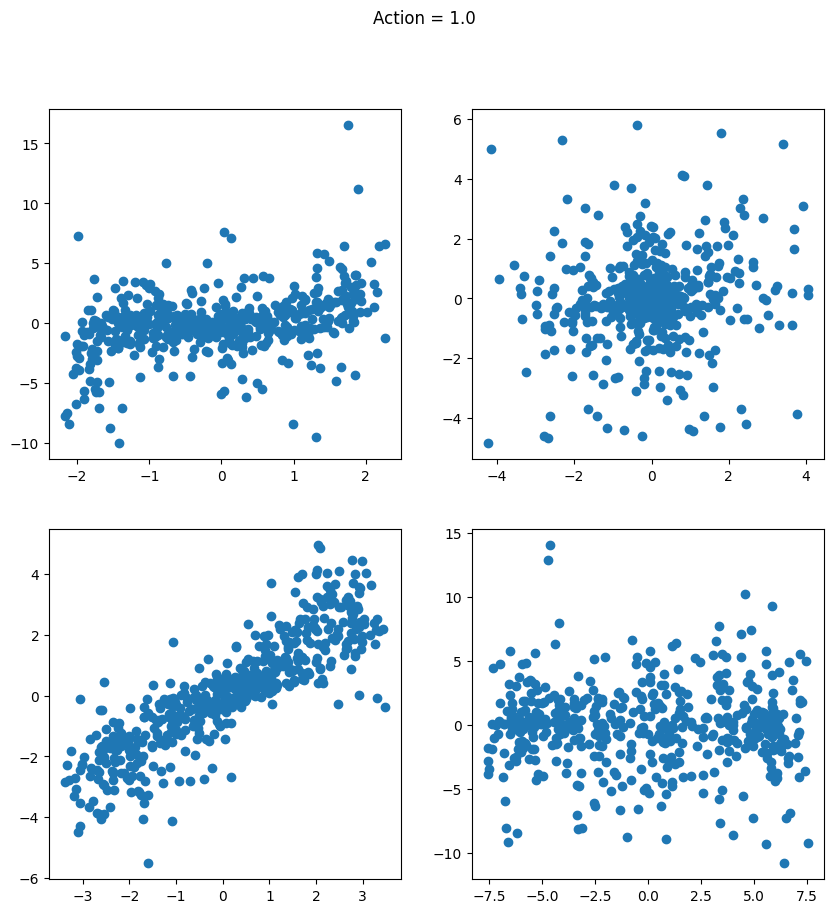

In [17]:
# Start off with action = 1.0 
# Collect a new set of data and retrain nonlinear model:

action = 1.0
XY, _ = make_XY_vectors_wforce(no_datapoints, data_gen_seeds, action)

M = 100
sig = [10, 10, 10, 10]
alpha_M, X_prime_indices, Y = nonlinear_model(XY_vectors, M, sig, lmda=20)


# Use the model for prediction
X = np.array([vec[0] for vec in XY_vectors])
X_prime = X[X_prime_indices]
K_NM = calculate_kernel(X, X_prime, sig)

Y_pred = K_NM @ alpha_M


# Scatter plot of predicted state against actual state 

fig, ax = plt.subplots(2,2,figsize=(10,10))
fig.suptitle(f"Action = {action}")
ax[0,0].scatter(Y.T[0], Y_pred.T[0]) 
ax[0,1].scatter(Y.T[1], Y_pred.T[1])
ax[1,0].scatter(Y.T[2], Y_pred.T[2])
ax[1,1].scatter(Y.T[3], Y_pred.T[3])
plt.show()

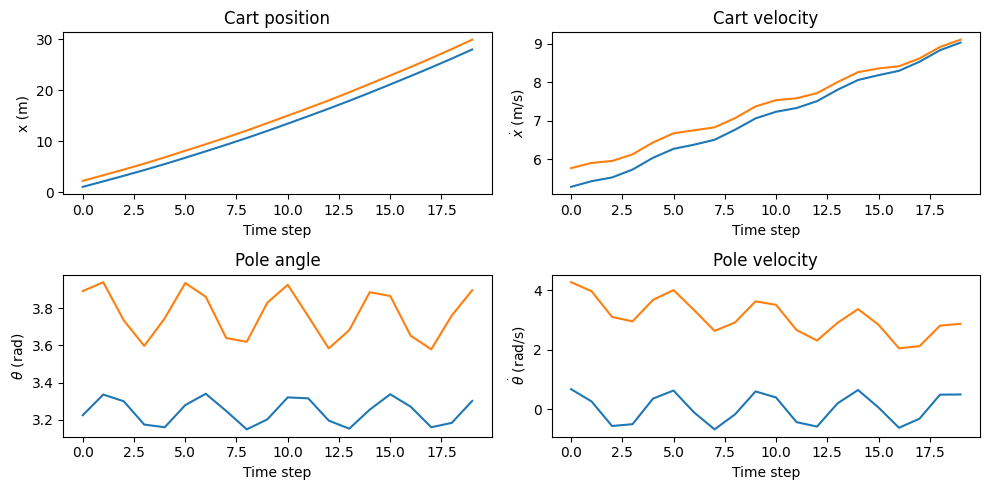

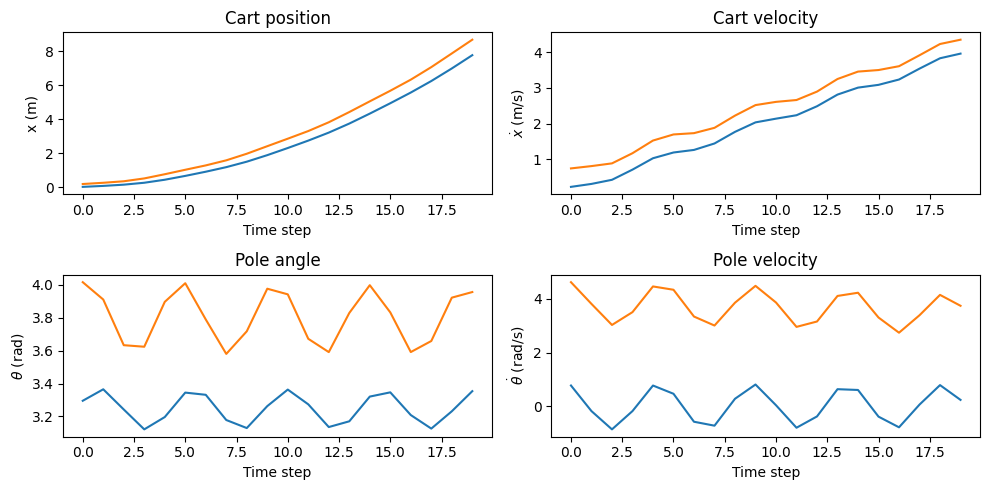

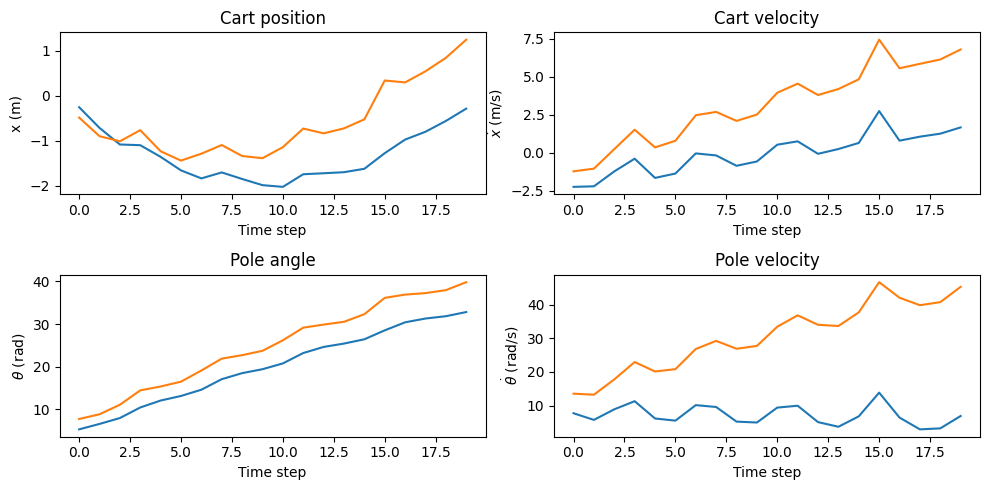

In [18]:
initial_state_linear = [0, 5, np.pi, 0]
initial_state_simple_osc = [0, 0, np.pi, 0.5]
initial_state_complete_rot = [0, 0, np.pi, 15]

n = 20

def test_prediction(initial_state, f, remap):
    cp.setState(initial_state)
    pred_state_list = []
    l_list = []
    v_list = []
    pa_list = []
    pv_list = []

    for _ in range(n):
        cp.performAction(f)
        if remap == True:
            cp.remap_angle()
        state = np.array([cp.cart_location,cp.cart_velocity, cp.pole_angle, cp.pole_velocity])
        l_list.append(state[0])   
        v_list.append(state[1])  
        pa_list.append(state[2])    
        pv_list.append(state[3]) 

        pred_state_list.append(np.matmul(state, C_opt) + state)
    
    times = np.arange(0,n,1)
    pred_state_list = np.array(pred_state_list)

    plt.figure(figsize=(10,5))
    plt.subplot(2,2,1)
    plt.plot(times, l_list)
    plt.plot(times, pred_state_list.T[0])
    plt.xlabel('Time step')
    plt.ylabel('x (m)')
    plt.title("Cart position")
    plt.subplot(2,2,2)
    plt.plot(times, v_list)
    plt.plot(times, pred_state_list.T[1])
    plt.xlabel('Time step')
    plt.ylabel(r'$\dot{x}$ (m/s)')
    plt.title("Cart velocity")
    plt.subplot(2,2,3)
    plt.plot(times, pa_list)
    plt.plot(times, pred_state_list.T[2])
    plt.xlabel('Time step')
    plt.ylabel(r'$\theta$ (rad)')
    plt.title("Pole angle")
    plt.subplot(2,2,4)
    plt.plot(times, pv_list)
    plt.plot(times, pred_state_list.T[3])
    plt.xlabel('Time step')
    plt.ylabel(r'$\dot{\theta}$ (rad/s)')
    plt.title("Pole velocity")
    plt.tight_layout()
    plt.show()



alpha_M, X_prime_indices, Y = nonlinear_model(XY_vectors, M, sig, lmda=20)

# Use the model for prediction
X = np.array([vec[0] for vec in XY_vectors])
X_prime = X[X_prime_indices]
K_NM = calculate_kernel(X, X_prime, sig)

Y_pred = K_NM @ alpha_M

test_prediction(initial_state_linear, 1, remap=False)
test_prediction(initial_state_simple_osc, 1, remap=False)
test_prediction(initial_state_complete_rot, 1, remap=False)
    

[[5542075.5083441    96185.87102933  446141.39154749 ...   57334.09748074
   782307.44112688  578825.14375056]
 [  96185.87102933   19716.61510956   19269.71735771 ...    7481.14066014
    26071.51034511   14997.2867229 ]
 [ 446141.39154749   19269.71735771   48301.53164771 ...    9189.54967565
    66395.5633177    53565.99176252]
 ...
 [  57334.09748074    7481.14066014    9189.54967565 ...    7012.66621161
    37207.60567666   19062.78931119]
 [ 782307.44112688   26071.51034511   66395.5633177  ...   37207.60567666
   903630.48318002  227450.0385595 ]
 [ 578825.14375056   14997.2867229    53565.99176252 ...   19062.78931119
   227450.0385595   158414.85653619]] [[-1.58374923e+04 -7.78621373e+03 -3.92661409e+04  2.85660391e+03]
 [-2.58253243e+01  4.91877495e+02  1.93857412e+03 -8.79911218e+02]
 [-2.24771280e+03 -1.44993648e+02 -1.43569478e+03 -1.35102400e+02]
 [ 2.92694884e+02  3.53715818e+02  8.96288130e+02 -1.93915257e+02]
 [ 6.30005220e+02  4.83189156e+02 -1.22279059e+04  5.1970120

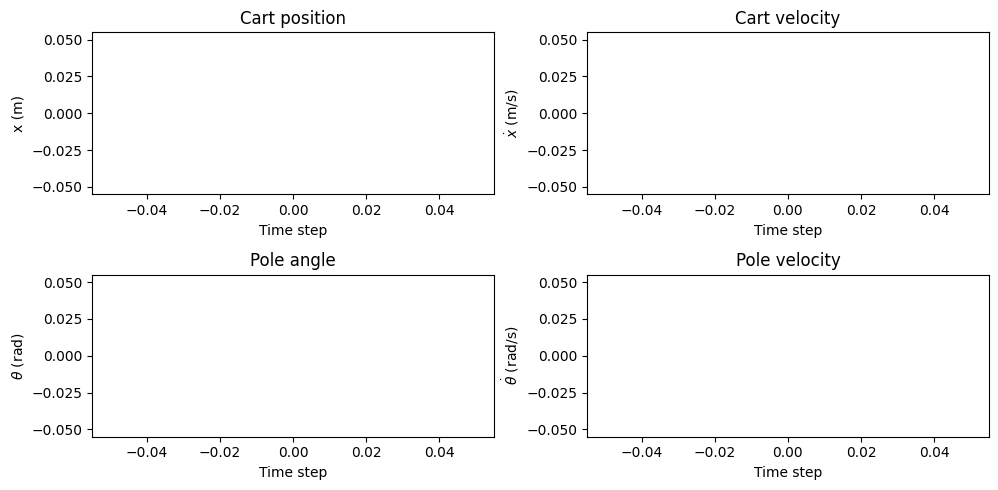

[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 ...
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]


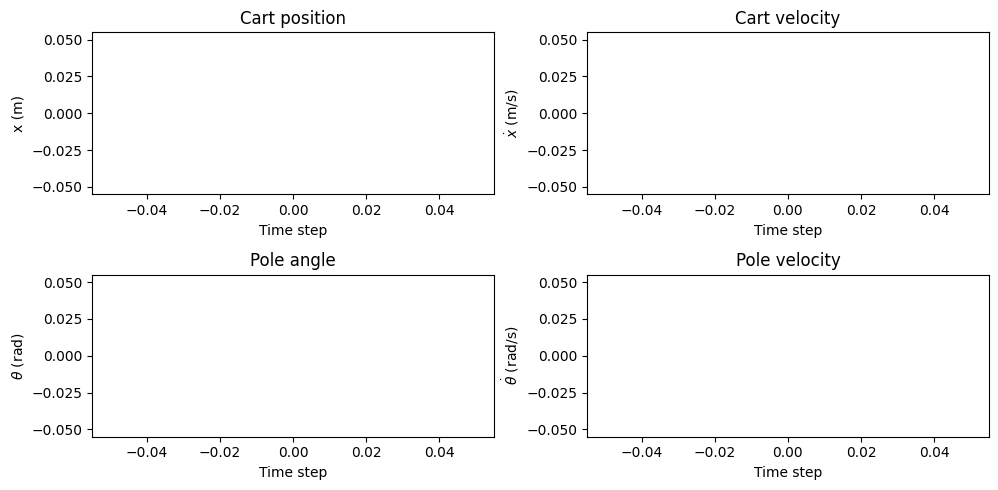

[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 ...
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]


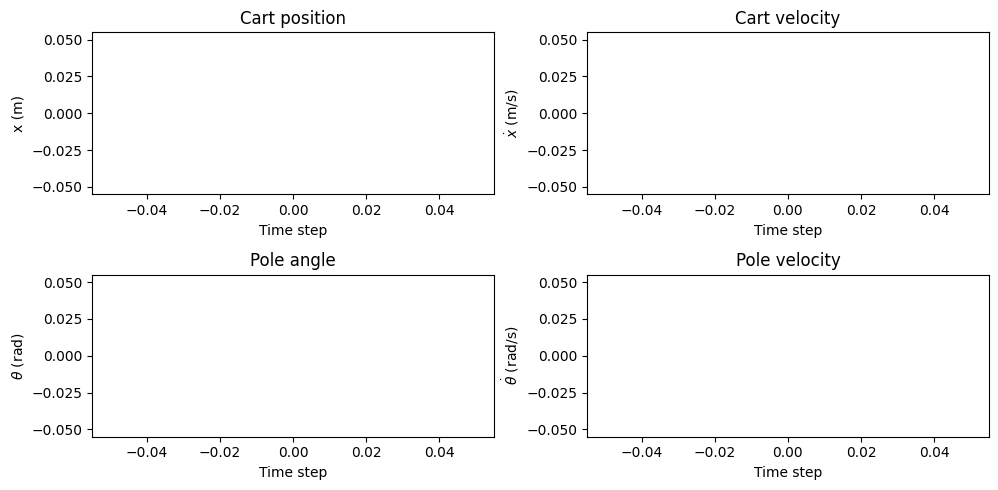

In [19]:

M = 100  # The number of basis functions
sig = [10,10,10,10]  # The scale factors for the four state variables respectively
lmda = 5  # The variance of the data 

def calculate_kernel(X, X_prime, sig):
    K = np.zeros((len(X), len(X_prime)))
    for i in range(len(X)):
        for j in range(len(X_prime)):
            exp_cl = (X[i][0] - X_prime[j][0])**2 / (2*sig[0]**2)
            exp_cv = (X[i][1] - X_prime[j][1])**2 / (2*sig[1]**2)
            exp_pa = np.sin((X[i][2] - X_prime[j][2])/2)**2 / (2*sig[2]**2)
            exp_pv = (X[i][3] - X_prime[j][3])**2 / (2*sig[3]**2)
            exponent = exp_cl + exp_cv + exp_pa + exp_pv
            K[i][j] = np.exp(exponent)
    return K

def nonlinear_model(XY, M, sig, lmda):
    X = np.array([vec[0] for vec in XY])
    Y = np.array([vec[1] for vec in XY])
    X_prime_indices = np.random.choice(len(X), size=M, replace=False, p=None)
    X_prime = X[X_prime_indices]
    K_NM = calculate_kernel(X, X_prime, sig)
    K_MM = calculate_kernel(X_prime, X_prime, sig)
    K_MN = K_NM.T
    a = np.matmul(K_MN, K_NM) + lmda * K_MM
    b = K_MN @ Y
    print(a, b)
    alpha_M = np.linalg.lstsq(a, b, rcond=None)[0]
    return alpha_M, X_prime_indices, Y


alpha_M, X_prime_indices, Y = nonlinear_model(XY, M, sig, lmda)  # XY is the list of vectors when there is an applied force

# Use the model for prediction
X = np.array([vec[0] for vec in XY_vectors])
X_prime = X[X_prime_indices]
K_NM = calculate_kernel(X, X_prime, sig)

n = 500

def test_prediction(initial_state, f, M, sig, lmda, remap):
    cp.setState(initial_state)
    pred_state_list = []
    l_list = []
    v_list = []
    pa_list = []
    pv_list = []

    for _ in range(n):
        cp.performAction(f)
        if remap == True:
            cp.remap_angle()
        state = np.array([cp.cart_location,cp.cart_velocity, cp.pole_angle, cp.pole_velocity])
        l_list.append(state[0])   
        v_list.append(state[1])  
        pa_list.append(state[2])    
        pv_list.append(state[3])
    
    X = np.array([l_list, v_list, pa_list, pv_list]).T
    X_prime = X[X_prime_indices]
    K_NM = calculate_kernel(X, X_prime, sig)

    pred_state_list = K_NM @ alpha_M    

        # pred_state_list.append(np.matmul(state, C_opt) + state)
    
    times = np.arange(0,n,1)
    pred_state_list = np.array(pred_state_list)

    print(pred_state_list)

    plt.figure(figsize=(10,5))
    plt.subplot(2,2,1)
    #plt.plot(times, l_list)
    plt.plot(times, pred_state_list.T[0])
    plt.xlabel('Time step')
    plt.ylabel('x (m)')
    plt.title("Cart position")
    plt.subplot(2,2,2)
    #plt.plot(times, v_list)
    plt.plot(times, pred_state_list.T[1])
    plt.xlabel('Time step')
    plt.ylabel(r'$\dot{x}$ (m/s)')
    plt.title("Cart velocity")
    plt.subplot(2,2,3)
    #plt.plot(times, pa_list)
    plt.plot(times, pred_state_list.T[2])
    plt.xlabel('Time step')
    plt.ylabel(r'$\theta$ (rad)')
    plt.title("Pole angle")
    plt.subplot(2,2,4)
    #plt.plot(times, pv_list)
    plt.plot(times, pred_state_list.T[3])
    plt.xlabel('Time step')
    plt.ylabel(r'$\dot{\theta}$ (rad/s)')
    plt.title("Pole velocity")
    plt.tight_layout()
    plt.show()



alpha_M, X_prime_indices, Y = nonlinear_model(XY_vectors, M, sig, lmda=20)

# Use the model for prediction
X = np.array([vec[0] for vec in XY_vectors])
X_prime = X[X_prime_indices]
K_NM = calculate_kernel(X, X_prime, sig)

Y_pred = K_NM @ alpha_M

test_prediction(initial_state_linear, 1, M, sig, lmda, remap=False)
test_prediction(initial_state_simple_osc, 1, M, sig, lmda, remap=False)
test_prediction(initial_state_complete_rot, 1, M, sig, lmda, remap=False)

### Objective

In order to optimize a policy, we need to define, mathematically, what we want to achieve. That is captured in an _objective function_ (also called
_loss function_), a measure of how close we are to the desired behaviour. In the present case, we want the pole to be upright,
so we could use the _loss function_

$$
l(X) = -\cos\theta
$$

But it is better, and more general, to define a _target state_, $X_0$, which we want the system to achieve, and use a loss
function that increases when the distance of the state from the target is larger. The following loss function achieves this, 

$$
l(X) = 1- e^{-|X-X_0|^2/2\sigma_l^2}
$$
where $\sigma_l$ is a scaling factor (you could introduce a separate one for each component of the state variable). The target
state for the cartpole system is $X_0 = [0,0,0,0]$. The advantage
of this form is that for large departures from the target, the loss is independent of the state. This expresses the notion
that if the pole is far away from being upright and stationary, we do not much care what it is doing. The above loss functions
are for a given state. We wish to keep the pole upright continuously, so the total loss of a trajectory should be a time
integral (sum, in practice) of the pointwise loss of the state over some interval,

$$
L = \sum_{i=1}^N l(X_i)
$$

The `CartPole` class contains a function to evaluate the above pointwise loss $l(X)$. 

### Linear control

We start with defining a linear policy, 

$$
p(X) = \bf{p} \cdot X
$$

with unknown coefficent vector ${\bf p}$. 

#### Task 2.3

Write code to evaluate the loss function for the trajectory of a rollout - use a short time horizon, but enough to capture 1-2 
oscillation periods. Before any optimisation, _visualise_ the loss function as you vary some parameters in ${\bf p}$, using 
similar 1D and 2D scans that you did for Task 1, i.e. varying just one or two elements of  ${\bf p}$ and plotting the loss 
as a function of those elements. 

Optimise the unknowns in the policy to minimise the loss function. Since you do not have too many variables, you can do this 
by looking at how the loss changes for small changes in policy variables. Feel free to use off-she-shelf optimizers, e.g. from 
the `scipy.optimize` package. For low dimensional optimization problems without gradients available, you can use the `Nelder-Mead` method. 

Do not expect the loss to be a simple function of the policy parameters, or to have only a few minima - it is likely that you need
to explore a variety of initial conditions. But there is not just one solution! Explore the loss as a function of the
elements of ${\bf p}$.  Find elements of ${\bf p}$ that are able to stabilize the pole when started just slightly displaced 
from the upright unstable position.

How close do you have to start? Plot the time evolution of the variables under the policy to demonstrate that the pole is kept upright. 

#### Task 2.4

In the previous task you used the real dynamics to evaluate a policy. But we have a good _model_ of the dynamics (the nonlinear
one from Task 2.1). Try to optimise the policy parameters by testing them on model-rollouts. 
You need to limit the time horizon (number of steps) to where you think your model is still 
accurate. (Using models to optimise policy is called _model predictive control_)



## Week 3: Sensitivity and stability

We go back to the beginning of the project, and modify the problem, introducing noise in various forms, and observe its effect. 

#### Task 3.1

Introduce noise in the _observed_ dynamics (but not in the real dynamics of the system). Refit the models (linear and nonlinear), 
and characterise the degradation in the prediction accuracy. Reoptimise the linear policy, and check its stability, contrasting it with the noise-free case.

#### Task 3.2

Introduce noise in the actual dynamics of the cartpole system, and repeat the tests of the previous task. 


## Week 4: Nonlinear control


#### Task 4.1

Define a _nonlinear_ policy, using a similar construction that we used for modelling the system, but this time we are modelling 
the `force` action as a function of the system state variables (i.e. the policy). The policy function is thus

$$
p(X) = \sum_i w_i e^{-0.5 (X-X_i)^T W (X-X_i)}
$$

where the locations $X_i$, the weights $w_i$ and the elements of the $4 \times 4$ symmetrix matrix $W$ are free parameters to be optimised (how do you make sure W is symmetric?). 
Use between 5-20  basis functions. Optimise the parameters, and try to obtain a policy that can keep the pole upright starting 
from the stable equilibrium (down) position. Feel free to use special initial conditions that seem reasonable. I suggest you experiment with the noise-free version of the problem.

_Note that this task is **hard**, and you may not achieve good control. Do not invest an inordinate amount of effort, but
move onto writing your final report if you do not succeed. You do not necessarily need to have found a good nonlinear controller to 
achieve a good grade in this project_, but I will be looking for good effort and evidence that you tried a variety of ideas. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c23f0d74-3042-4735-a425-5112e03d85a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>